## データの読込

In [2]:
import pandas as pd
df = pd.read_csv("vgsales-12-4-2019.csv")
df.head(3)

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,...,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,...,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,...,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,...,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg


## 外れ値の検証

In [3]:
import os
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted 

import optuna.integration.lightgbm as lgb
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE

from sklearn.ensemble import IsolationForest

import warnings
warnings.simplefilter('ignore')

In [4]:
# シード値の固定
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df.dropna(subset=["Global_Sales"]).drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1), 
                                                    df.dropna(subset=["Global_Sales"])["Global_Sales"],  
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=SEED
                                                    ) 

In [6]:
### 欠損値補完
X_train_ff = X_train.fillna(method='ffill')
X_test_ff = X_test.fillna(method='ffill')

#### カテゴリーエンコーディング

# ユニーク数に応じてカラムを分割する
category_unique_num = X_train_ff.select_dtypes(include="object").nunique()

few_kinds_category_columns = category_unique_num[category_unique_num < 10].index
many_kinds_category_columns = category_unique_num[category_unique_num >= 10].index


# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping_ce = []

for i, column in enumerate(many_kinds_category_columns):
    ordinal_one_cols_mapping = {}
    ordinal_one_cols_mapping_breakdown = {}
    for j, category in enumerate(natsorted(X_train_ff[column].unique())):
        ordinal_one_cols_mapping_breakdown[category] = j

    ordinal_one_cols_mapping["col"] = column
    ordinal_one_cols_mapping["mapping"] = ordinal_one_cols_mapping_breakdown
    ordinal_all_cols_mapping_ce.append(ordinal_one_cols_mapping)


# エンコーディング設定
ode = ce.OrdinalEncoder(
    mapping = ordinal_all_cols_mapping_ce,
    cols = many_kinds_category_columns
)

ohe = ce.OneHotEncoder(
    use_cat_names=True,
    cols = few_kinds_category_columns
)

# 元データをコピー
X_train_ce = X_train_ff.copy()
X_test_ce = X_test_ff.copy()

# OneHotEncoder
X_train_ce = ohe.fit_transform(X_train_ce)
X_test_ce = ohe.transform(X_test_ce)

# OrdinalHotEncoder
X_train_ce = ode.fit_transform(X_train_ce)
X_test_ce = ode.transform(X_test_ce)

# 正規化
sc = StandardScaler()
X_train_ce = pd.DataFrame(
                            sc.fit_transform(X_train_ce),
                            columns=X_train_ce.columns
                            )

X_test_ce = pd.DataFrame(
                            sc.transform(X_test_ce),
                            columns=X_test_ce.columns
                            )

In [7]:
# 欠損値補完直後のデータを対象
X_train_ff = X_train_ce.fillna(method='ffill')
X_test_ff = X_test_ce.fillna(method='ffill')

# IsolationForest はNaN非対応なので削除
X_train_dropna = X_train_ff.dropna(how="all", axis=1)
X_train_dropna = X_train_dropna.dropna(how="any", axis=0)

X_test_dropna = X_test_ff.dropna(how="all", axis=1)
X_test_dropna = X_test_dropna.dropna(how="any", axis=0)


# X の欠損行を削除したので、y もそれに合わせる
y_train = y_train.reset_index(drop=True)
y_train_dropna = y_train[y_train.index.isin(X_train_dropna.index)]

y_test = y_test.reset_index(drop=True)
y_test_dropna = y_test[y_test.index.isin(X_test_dropna.index)]

[I 2021-12-27 16:27:56,842] A new study created in memory with name: no-name-39432184-653b-4ba0-8de5-933beb0b51a2
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.337946:  14%|######4                                      | 1/7 [00:00<00:04,  1.48it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.124582	Test's rmse: 0.337946
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.337946:  29%|############8                                | 2/7 [00:01<00:03,  1.59it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12444	Test's rmse: 0.357704
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.337946:  43%|###################2                         | 3/7 [00:01<00:02,  1.58it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.116941	Test's rmse: 0.364497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.337946:  57%|#########################7                   | 4/7 [00:02<00:01,  1.51it/s]

Early stopping, best iteration is:
[40]	Train's rmse: 0.150359	Test's rmse: 0.349063
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.337946:  71%|################################1            | 5/7 [00:03<00:01,  1.57it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.110067	Test's rmse: 0.357953
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.337946:  86%|######################################5      | 6/7 [00:03<00:00,  1.63it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.151631	Test's rmse: 0.349575
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.337946: 100%|#############################################| 7/7 [00:04<00:00,  1.65it/s]


Early stopping, best iteration is:
[34]	Train's rmse: 0.153648	Test's rmse: 0.345486


num_leaves, val_score: 0.337946:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.337550:   5%|##5                                               | 1/20 [00:02<00:56,  2.97s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119603	Test's rmse: 0.33755
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.337550:  10%|#####                                             | 2/20 [00:04<00:39,  2.22s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119385	Test's rmse: 0.33856
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.337550:  15%|#######5                                          | 3/20 [00:06<00:32,  1.93s/it]

Early stopping, best iteration is:
[49]	Train's rmse: 0.142027	Test's rmse: 0.338869
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.337550:  20%|##########                                        | 4/20 [00:08<00:31,  2.00s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119984	Test's rmse: 0.338101
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.337238:  25%|############5                                     | 5/20 [00:09<00:27,  1.84s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119886	Test's rmse: 0.337238
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.337238:  30%|###############                                   | 6/20 [00:11<00:24,  1.75s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119796	Test's rmse: 0.337312
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.337238:  35%|#################5                                | 7/20 [00:11<00:16,  1.24s/it]

Early stopping, best iteration is:
[49]	Train's rmse: 0.144042	Test's rmse: 0.338586
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.337238:  40%|####################                              | 8/20 [00:12<00:14,  1.24s/it]

Early stopping, best iteration is:
[49]	Train's rmse: 0.138436	Test's rmse: 0.338723
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.337238:  45%|######################5                           | 9/20 [00:15<00:16,  1.54s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.123413	Test's rmse: 0.338706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.337238:  50%|########################5                        | 10/20 [00:19<00:23,  2.36s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119897	Test's rmse: 0.338603
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.337238:  55%|##########################9                      | 11/20 [00:21<00:21,  2.37s/it]

Early stopping, best iteration is:
[45]	Train's rmse: 0.141018	Test's rmse: 0.338554
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.337238:  60%|#############################4                   | 12/20 [00:24<00:19,  2.44s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119906	Test's rmse: 0.337307
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.337238:  65%|###############################8                 | 13/20 [00:26<00:17,  2.48s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119908	Test's rmse: 0.337249
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.337238:  70%|##################################3              | 14/20 [00:28<00:13,  2.30s/it]

Early stopping, best iteration is:
[38]	Train's rmse: 0.148317	Test's rmse: 0.338632
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.336295:  75%|####################################7            | 15/20 [00:29<00:09,  1.96s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.120578	Test's rmse: 0.336295
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.336295:  80%|#######################################2         | 16/20 [00:31<00:06,  1.72s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.123767	Test's rmse: 0.338475
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.336295:  85%|#########################################6       | 17/20 [00:32<00:04,  1.61s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12358	Test's rmse: 0.337945
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.336238:  90%|############################################1    | 18/20 [00:33<00:02,  1.46s/it]

Early stopping, best iteration is:
[49]	Train's rmse: 0.139748	Test's rmse: 0.336238
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.336238:  95%|##############################################5  | 19/20 [00:34<00:01,  1.17s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.125457	Test's rmse: 0.343879
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.336238: 100%|#################################################| 20/20 [00:35<00:00,  1.77s/it]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.125035	Test's rmse: 0.338985


bagging, val_score: 0.336238:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.319130:  10%|#####3                                               | 1/10 [00:01<00:10,  1.17s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.159024	Test's rmse: 0.31913
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.319130:  20%|##########6                                          | 2/10 [00:02<00:09,  1.20s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161615	Test's rmse: 0.319892
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.315448:  30%|###############9                                     | 3/10 [00:03<00:08,  1.26s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154821	Test's rmse: 0.315448
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.315448:  40%|#####################2                               | 4/10 [00:05<00:07,  1.27s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142819	Test's rmse: 0.317161
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.315448:  50%|##########################5                          | 5/10 [00:06<00:07,  1.44s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140735	Test's rmse: 0.323196
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.315448:  60%|###############################8                     | 6/10 [00:08<00:06,  1.61s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161004	Test's rmse: 0.326461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.315448:  70%|#####################################                | 7/10 [00:10<00:05,  1.70s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154429	Test's rmse: 0.316894
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.315448:  80%|##########################################4          | 8/10 [00:12<00:03,  1.69s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141807	Test's rmse: 0.325098
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.315448:  90%|###############################################7     | 9/10 [00:14<00:01,  1.71s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.167371	Test's rmse: 0.324878
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.315448: 100%|####################################################| 10/10 [00:15<00:00,  1.56s/it]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16772	Test's rmse: 0.318674


feature_fraction_stage2, val_score: 0.315448:   0%|                                              | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.315448:  17%|######3                               | 1/6 [00:01<00:09,  1.85s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.159806	Test's rmse: 0.322681
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.315448:  33%|############6                         | 2/6 [00:03<00:07,  1.78s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136005	Test's rmse: 0.321714
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.315448:  50%|###################                   | 3/6 [00:06<00:06,  2.09s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142545	Test's rmse: 0.317549
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.315448:  67%|#########################3            | 4/6 [00:10<00:06,  3.02s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.155238	Test's rmse: 0.318297
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.315448:  83%|###############################6      | 5/6 [00:13<00:02,  2.92s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154821	Test's rmse: 0.315448
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.315448: 100%|######################################| 6/6 [00:16<00:00,  2.67s/it]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154821	Test's rmse: 0.315448


regularization_factors, val_score: 0.315448:   0%|                                              | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

regularization_factors, val_score: 0.315448:   5%|#9                                    | 1/20 [00:02<00:53,  2.80s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152839	Test's rmse: 0.321763
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.315448:  10%|###8                                  | 2/20 [00:07<01:05,  3.66s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15454	Test's rmse: 0.318578
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.315402:  15%|#####7                                | 3/20 [00:08<00:45,  2.69s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154771	Test's rmse: 0.315402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

regularization_factors, val_score: 0.315402:  20%|#######6                              | 4/20 [00:09<00:34,  2.17s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.155754	Test's rmse: 0.316786
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

regularization_factors, val_score: 0.315402:  25%|#########5                            | 5/20 [00:10<00:22,  1.52s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15325	Test's rmse: 0.330214
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

regularization_factors, val_score: 0.315402:  30%|###########4                          | 6/20 [00:10<00:15,  1.13s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145476	Test's rmse: 0.332243
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.315402:  35%|#############3                        | 7/20 [00:11<00:14,  1.13s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154771	Test's rmse: 0.315402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.315402:  40%|###############2                      | 8/20 [00:13<00:13,  1.17s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154771	Test's rmse: 0.315402
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

regularization_factors, val_score: 0.315402:  45%|#################1                    | 9/20 [00:14<00:13,  1.22s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.149662	Test's rmse: 0.317915
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

regularization_factors, val_score: 0.314844:  50%|##################5                  | 10/20 [00:15<00:11,  1.17s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151113	Test's rmse: 0.314844
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

regularization_factors, val_score: 0.314844:  55%|####################3                | 11/20 [00:17<00:13,  1.46s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151302	Test's rmse: 0.317785
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.314844:  60%|######################2              | 12/20 [00:21<00:17,  2.25s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154768	Test's rmse: 0.315446
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

regularization_factors, val_score: 0.314844:  65%|########################             | 13/20 [00:24<00:16,  2.31s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.158811	Test's rmse: 0.314976
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

regularization_factors, val_score: 0.314844:  70%|#########################9           | 14/20 [00:26<00:13,  2.27s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.159741	Test's rmse: 0.319235
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

regularization_factors, val_score: 0.314844:  75%|###########################7         | 15/20 [00:28<00:11,  2.21s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152697	Test's rmse: 0.318297
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.314844:  80%|#############################6       | 16/20 [00:30<00:08,  2.21s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15452	Test's rmse: 0.316829
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

regularization_factors, val_score: 0.314123:  85%|###############################4     | 17/20 [00:32<00:06,  2.22s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.1496	Test's rmse: 0.314123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.314123:  90%|#################################3   | 18/20 [00:35<00:04,  2.23s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.153254	Test's rmse: 0.314866
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

regularization_factors, val_score: 0.311033:  95%|###################################1 | 19/20 [00:36<00:02,  2.01s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148873	Test's rmse: 0.311033
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

regularization_factors, val_score: 0.311033: 100%|#####################################| 20/20 [00:37<00:00,  1.89s/it]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148662	Test's rmse: 0.314267


min_data_in_leaf, val_score: 0.311033:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

min_data_in_leaf, val_score: 0.311033:  20%|#########                                    | 1/5 [00:01<00:06,  1.53s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0296035	Test's rmse: 0.31582
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

min_data_in_leaf, val_score: 0.311033:  40%|##################                           | 2/5 [00:02<00:03,  1.29s/it]

Early stopping, best iteration is:
[33]	Train's rmse: 0.131589	Test's rmse: 0.331195
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

min_data_in_leaf, val_score: 0.311033:  60%|###########################                  | 3/5 [00:03<00:02,  1.30s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.155452	Test's rmse: 0.318145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further

min_data_in_leaf, val_score: 0.311033:  80%|####################################         | 4/5 [00:05<00:01,  1.19s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.219021	Test's rmse: 0.374384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001605 seconds.
You can set `force_col_wise=true` to remove 

min_data_in_leaf, val_score: 0.311033: 100%|#############################################| 5/5 [00:05<00:00,  1.19s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

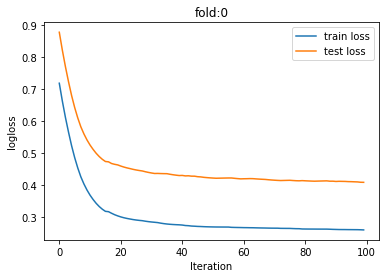

[I 2021-12-27 16:29:52,239] A new study created in memory with name: no-name-7e0dbb5a-6e3c-4cbe-9acb-50cc1a548be6
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.110042:  14%|######4                                      | 1/7 [00:00<00:05,  1.15it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134532	Test's rmse: 0.110042
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.110042:  29%|############8                                | 2/7 [00:01<00:04,  1.06it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137597	Test's rmse: 0.142042
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.110042:  43%|###################2                         | 3/7 [00:02<00:03,  1.04it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15304	Test's rmse: 0.112563
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.110042:  57%|#########################7                   | 4/7 [00:03<00:02,  1.02it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148377	Test's rmse: 0.117394
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.110042:  71%|################################1            | 5/7 [00:05<00:02,  1.09s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137518	Test's rmse: 0.137881
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.110042:  86%|######################################5      | 6/7 [00:06<00:01,  1.28s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127015	Test's rmse: 0.11363
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.110042: 100%|#############################################| 7/7 [00:08<00:00,  1.15s/it]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128122	Test's rmse: 0.121327


num_leaves, val_score: 0.110042:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.110042:   5%|##5                                               | 1/20 [00:01<00:25,  1.37s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.177546	Test's rmse: 0.11702
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.110042:  10%|#####                                             | 2/20 [00:06<00:59,  3.32s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136231	Test's rmse: 0.116191
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.106158:  15%|#######5                                          | 3/20 [00:07<00:39,  2.32s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134558	Test's rmse: 0.106158
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.106158:  20%|##########                                        | 4/20 [00:11<00:46,  2.92s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141491	Test's rmse: 0.118393
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.106158:  25%|############5                                     | 5/20 [00:16<01:00,  4.00s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139595	Test's rmse: 0.116141
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.106158:  30%|###############                                   | 6/20 [00:24<01:14,  5.33s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138343	Test's rmse: 0.1172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.106158:  35%|#################5                                | 7/20 [00:33<01:24,  6.52s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135149	Test's rmse: 0.113746
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.106158:  40%|####################                              | 8/20 [00:35<00:58,  4.89s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134569	Test's rmse: 0.109579
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.106158:  45%|######################5                           | 9/20 [00:37<00:44,  4.05s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134145	Test's rmse: 0.111267
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.106158:  50%|########################5                        | 10/20 [00:42<00:44,  4.45s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133087	Test's rmse: 0.111488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.106158:  55%|##########################9                      | 11/20 [00:49<00:46,  5.20s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136685	Test's rmse: 0.113509
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.106158:  60%|#############################4                   | 12/20 [00:51<00:32,  4.04s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134933	Test's rmse: 0.108545
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.106158:  65%|###############################8                 | 13/20 [00:53<00:24,  3.48s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130979	Test's rmse: 0.109956
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.106158:  70%|##################################3              | 14/20 [00:55<00:18,  3.10s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13872	Test's rmse: 0.110437
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.106158:  75%|####################################7            | 15/20 [00:55<00:11,  2.29s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143019	Test's rmse: 0.111925
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.106158:  80%|#######################################2         | 16/20 [00:57<00:08,  2.01s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134546	Test's rmse: 0.108341
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.106158:  85%|#########################################6       | 17/20 [01:00<00:06,  2.29s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134427	Test's rmse: 0.111402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.106158:  90%|############################################1    | 18/20 [01:01<00:04,  2.01s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134933	Test's rmse: 0.108545
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.106158:  95%|##############################################5  | 19/20 [01:04<00:02,  2.31s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141846	Test's rmse: 0.11826
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.106158: 100%|#################################################| 20/20 [01:06<00:00,  3.32s/it]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134503	Test's rmse: 0.108108


bagging, val_score: 0.106158:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.106158:  10%|#####3                                               | 1/10 [00:01<00:09,  1.05s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.181483	Test's rmse: 0.122514
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.106158:  20%|##########6                                          | 2/10 [00:02<00:08,  1.03s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.155807	Test's rmse: 0.113333
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.106158:  30%|###############9                                     | 3/10 [00:03<00:07,  1.05s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136207	Test's rmse: 0.106897
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.106158:  40%|#####################2                               | 4/10 [00:04<00:06,  1.05s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.177182	Test's rmse: 0.11245
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.106158:  50%|##########################5                          | 5/10 [00:05<00:04,  1.02it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.217779	Test's rmse: 0.111623
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.106158:  60%|###############################8                     | 6/10 [00:06<00:04,  1.01s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.211339	Test's rmse: 0.138485
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.106158:  70%|#####################################                | 7/10 [00:07<00:03,  1.01s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.160701	Test's rmse: 0.114698
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.106158:  80%|##########################################4          | 8/10 [00:08<00:02,  1.01s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.188713	Test's rmse: 0.108914
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.106158:  90%|###############################################7     | 9/10 [00:09<00:01,  1.01s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16519	Test's rmse: 0.110595
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.106158: 100%|####################################################| 10/10 [00:10<00:00,  1.01s/it]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.184213	Test's rmse: 0.119722


feature_fraction_stage2, val_score: 0.106158:   0%|                                              | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.106158:  17%|######3                               | 1/6 [00:00<00:04,  1.09it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13018	Test's rmse: 0.110134
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.106158:  33%|############6                         | 2/6 [00:02<00:05,  1.28s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134558	Test's rmse: 0.106158
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.106158:  50%|###################                   | 3/6 [00:03<00:03,  1.23s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145464	Test's rmse: 0.111916
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.106158:  67%|#########################3            | 4/6 [00:04<00:02,  1.08s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134558	Test's rmse: 0.106158
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.106158:  83%|###############################6      | 5/6 [00:05<00:01,  1.02s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142503	Test's rmse: 0.108106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.106158: 100%|######################################| 6/6 [00:06<00:00,  1.04s/it]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131103	Test's rmse: 0.108658


regularization_factors, val_score: 0.106158:   0%|                                              | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.106158:   5%|#9                                    | 1/20 [00:00<00:16,  1.18it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135538	Test's rmse: 0.107374
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.106158:  10%|###8                                  | 2/20 [00:01<00:15,  1.18it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134997	Test's rmse: 0.10856
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.106158:  15%|#####7                                | 3/20 [00:02<00:14,  1.14it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134558	Test's rmse: 0.106158
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.104917:  20%|#######6                              | 4/20 [00:03<00:13,  1.16it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131567	Test's rmse: 0.104917
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

regularization_factors, val_score: 0.104917:  25%|#########5                            | 5/20 [00:04<00:12,  1.18it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130562	Test's rmse: 0.108467
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.104917:  30%|###########4                          | 6/20 [00:05<00:11,  1.17it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132174	Test's rmse: 0.106736
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.104270:  35%|#############3                        | 7/20 [00:05<00:11,  1.17it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134247	Test's rmse: 0.10427
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.104270:  40%|###############2                      | 8/20 [00:07<00:10,  1.09it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132175	Test's rmse: 0.106736
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.104270:  45%|#################1                    | 9/20 [00:07<00:09,  1.12it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131732	Test's rmse: 0.104965
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.103177:  50%|##################5                  | 10/20 [00:08<00:08,  1.12it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133009	Test's rmse: 0.103177
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.103177:  55%|####################3                | 11/20 [00:09<00:08,  1.08it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134547	Test's rmse: 0.106151
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


regularization_factors, val_score: 0.103177:  60%|######################2              | 12/20 [00:10<00:07,  1.13it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139298	Test's rmse: 0.111764
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.103177:  65%|########################             | 13/20 [00:11<00:06,  1.03it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133144	Test's rmse: 0.105147
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.103177:  70%|#########################9           | 14/20 [00:12<00:05,  1.02it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132177	Test's rmse: 0.106736
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.103177:  75%|###########################7         | 15/20 [00:13<00:04,  1.07it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131158	Test's rmse: 0.106998
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.103177:  80%|#############################6       | 16/20 [00:14<00:03,  1.10it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134558	Test's rmse: 0.106158
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

regularization_factors, val_score: 0.103177:  85%|###############################4     | 17/20 [00:15<00:02,  1.20it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150026	Test's rmse: 0.116096
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of

regularization_factors, val_score: 0.103177:  90%|#################################3   | 18/20 [00:16<00:01,  1.06it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134559	Test's rmse: 0.106158
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.103177:  95%|###################################1 | 19/20 [00:17<00:00,  1.14it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132174	Test's rmse: 0.106736
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.103177: 100%|#####################################| 20/20 [00:17<00:00,  1.13it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133868	Test's rmse: 0.106963


min_data_in_leaf, val_score: 0.103177:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.094006:  20%|#########                                    | 1/5 [00:01<00:04,  1.18s/it]

Early stopping, best iteration is:
[40]	Train's rmse: 0.130548	Test's rmse: 0.0940056
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.094006:  40%|##################                           | 2/5 [00:02<00:04,  1.45s/it]

Early stopping, best iteration is:
[44]	Train's rmse: 0.261895	Test's rmse: 0.183534
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.094006:  60%|###########################                  | 3/5 [00:04<00:03,  1.55s/it]

Early stopping, best iteration is:
[37]	Train's rmse: 0.0757819	Test's rmse: 0.112957
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.094006:  80%|####################################         | 4/5 [00:06<00:01,  1.66s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.155804	Test's rmse: 0.118087
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.094006: 100%|#############################################| 5/5 [00:07<00:00,  1.50s/it]

Early stopping, best iteration is:
[22]	Train's rmse: 0.342291	Test's rmse: 0.227972


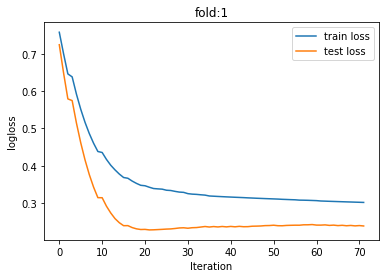

[I 2021-12-27 16:31:48,675] A new study created in memory with name: no-name-0d8bb431-f148-496b-b46c-41ad4fb0ab5b
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.163224:  14%|######4                                      | 1/7 [00:01<00:07,  1.29s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138513	Test's rmse: 0.163224
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.139513:  29%|############8                                | 2/7 [00:02<00:06,  1.37s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135018	Test's rmse: 0.139513
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.138658:  43%|###################2                         | 3/7 [00:03<00:04,  1.16s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132057	Test's rmse: 0.138658
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.138658:  57%|#########################7                   | 4/7 [00:04<00:03,  1.07s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140832	Test's rmse: 0.141138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.138658:  71%|################################1            | 5/7 [00:05<00:02,  1.00s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133245	Test's rmse: 0.154021
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.138658:  86%|######################################5      | 6/7 [00:06<00:00,  1.05it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14364	Test's rmse: 0.14255
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.138658: 100%|#############################################| 7/7 [00:07<00:00,  1.03s/it]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13314	Test's rmse: 0.147936


num_leaves, val_score: 0.138658:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138658:   5%|##5                                               | 1/20 [00:01<00:33,  1.77s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13104	Test's rmse: 0.140827
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138658:  10%|#####                                             | 2/20 [00:03<00:31,  1.73s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138944	Test's rmse: 0.142274
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138658:  15%|#######5                                          | 3/20 [00:07<00:46,  2.75s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134859	Test's rmse: 0.144465
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138658:  20%|##########                                        | 4/20 [00:09<00:41,  2.57s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130812	Test's rmse: 0.139762
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138658:  25%|############5                                     | 5/20 [00:12<00:41,  2.78s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132753	Test's rmse: 0.142272
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138658:  30%|###############                                   | 6/20 [00:17<00:45,  3.24s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135216	Test's rmse: 0.14424
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138658:  35%|#################5                                | 7/20 [00:19<00:40,  3.08s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129279	Test's rmse: 0.142794
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138658:  40%|####################                              | 8/20 [00:26<00:49,  4.10s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128705	Test's rmse: 0.143578
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138658:  45%|######################5                           | 9/20 [00:29<00:43,  3.96s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12894	Test's rmse: 0.142786
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138658:  50%|########################5                        | 10/20 [00:33<00:37,  3.77s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129129	Test's rmse: 0.140684
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138658:  55%|##########################9                      | 11/20 [00:33<00:24,  2.72s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.157735	Test's rmse: 0.148351
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138658:  60%|#############################4                   | 12/20 [00:35<00:20,  2.59s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130038	Test's rmse: 0.140248
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138658:  65%|###############################8                 | 13/20 [00:38<00:18,  2.65s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130073	Test's rmse: 0.138689
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138658:  70%|##################################3              | 14/20 [00:39<00:13,  2.25s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130175	Test's rmse: 0.141518
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138658:  75%|####################################7            | 15/20 [00:42<00:11,  2.39s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128693	Test's rmse: 0.141272
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138182:  80%|#######################################2         | 16/20 [00:43<00:08,  2.05s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134306	Test's rmse: 0.138182
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.137775:  85%|#########################################6       | 17/20 [00:44<00:05,  1.71s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131866	Test's rmse: 0.137775
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.137775:  90%|############################################1    | 18/20 [00:44<00:02,  1.27s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.177788	Test's rmse: 0.155096
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.137775:  95%|##############################################5  | 19/20 [00:45<00:01,  1.16s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132636	Test's rmse: 0.139808
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.137775: 100%|#################################################| 20/20 [00:46<00:00,  2.34s/it]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131316	Test's rmse: 0.139637


bagging, val_score: 0.137775:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.137775:  10%|#####3                                               | 1/10 [00:00<00:06,  1.29it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.185079	Test's rmse: 0.148795
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.137775:  20%|##########6                                          | 2/10 [00:01<00:06,  1.26it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.180464	Test's rmse: 0.153455
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.137775:  30%|###############9                                     | 3/10 [00:02<00:05,  1.28it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.165043	Test's rmse: 0.153083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.137775:  40%|#####################2                               | 4/10 [00:02<00:04,  1.41it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182267	Test's rmse: 0.15044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.137775:  50%|##########################5                          | 5/10 [00:03<00:03,  1.34it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172352	Test's rmse: 0.152412
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.137775:  60%|###############################8                     | 6/10 [00:04<00:03,  1.11it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.170222	Test's rmse: 0.155118
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.137775:  70%|#####################################                | 7/10 [00:06<00:03,  1.06s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.183407	Test's rmse: 0.147956
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.137775:  80%|##########################################4          | 8/10 [00:07<00:02,  1.16s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.176108	Test's rmse: 0.156265
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.137775:  90%|###############################################7     | 9/10 [00:08<00:01,  1.17s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.189512	Test's rmse: 0.149522
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.137775: 100%|####################################################| 10/10 [00:09<00:00,  1.02it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.180969	Test's rmse: 0.164253


feature_fraction_stage2, val_score: 0.137775:   0%|                                              | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.137775:  17%|######3                               | 1/6 [00:00<00:03,  1.31it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131866	Test's rmse: 0.137775
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.137775:  33%|############6                         | 2/6 [00:01<00:03,  1.27it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133192	Test's rmse: 0.140312
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.137775:  50%|###################                   | 3/6 [00:02<00:02,  1.27it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141285	Test's rmse: 0.139313
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.137775:  67%|#########################3            | 4/6 [00:03<00:01,  1.30it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142442	Test's rmse: 0.14018
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.137775:  83%|###############################6      | 5/6 [00:03<00:00,  1.32it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131866	Test's rmse: 0.137775
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.137775: 100%|######################################| 6/6 [00:04<00:00,  1.30it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134688	Test's rmse: 0.138223


regularization_factors, val_score: 0.137775:   0%|                                              | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.137775:   5%|#9                                    | 1/20 [00:00<00:15,  1.26it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131866	Test's rmse: 0.137775
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

regularization_factors, val_score: 0.137775:  10%|###8                                  | 2/20 [00:01<00:13,  1.38it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130298	Test's rmse: 0.148911
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.137775:  15%|#####7                                | 3/20 [00:02<00:12,  1.38it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13459	Test's rmse: 0.148812
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.137775:  20%|#######6                              | 4/20 [00:02<00:11,  1.34it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135864	Test's rmse: 0.139139
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.137775:  25%|#########5                            | 5/20 [00:03<00:11,  1.35it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133227	Test's rmse: 0.139979
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.137775:  30%|###########4                          | 6/20 [00:04<00:10,  1.35it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131866	Test's rmse: 0.137775
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.137526:  35%|#############3                        | 7/20 [00:05<00:09,  1.36it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135966	Test's rmse: 0.137526
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.137526:  40%|###############2                      | 8/20 [00:05<00:08,  1.36it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131866	Test's rmse: 0.137775
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.137526:  45%|#################1                    | 9/20 [00:06<00:07,  1.38it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137083	Test's rmse: 0.13935
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.137526:  50%|##################5                  | 10/20 [00:07<00:07,  1.35it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136213	Test's rmse: 0.151321
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.137526:  55%|####################3                | 11/20 [00:08<00:06,  1.37it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132298	Test's rmse: 0.141377
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.137526:  60%|######################2              | 12/20 [00:08<00:05,  1.37it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131866	Test's rmse: 0.137775
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.137526:  65%|########################             | 13/20 [00:09<00:05,  1.37it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135854	Test's rmse: 0.138916
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.137526:  70%|#########################9           | 14/20 [00:10<00:04,  1.33it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131866	Test's rmse: 0.137775
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.137444:  75%|###########################7         | 15/20 [00:11<00:03,  1.34it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136057	Test's rmse: 0.137444
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.137444:  80%|#############################6       | 16/20 [00:11<00:02,  1.36it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136059	Test's rmse: 0.137444
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.137444:  85%|###############################4     | 17/20 [00:12<00:02,  1.37it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136059	Test's rmse: 0.137444
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.137444:  90%|#################################3   | 18/20 [00:13<00:01,  1.34it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136773	Test's rmse: 0.138818
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.137444:  95%|###################################1 | 19/20 [00:14<00:00,  1.35it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133028	Test's rmse: 0.138972
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.137444: 100%|#####################################| 20/20 [00:14<00:00,  1.35it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136121	Test's rmse: 0.13818


min_data_in_leaf, val_score: 0.137444:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.132273:  20%|#########                                    | 1/5 [00:00<00:02,  1.43it/s]

Early stopping, best iteration is:
[38]	Train's rmse: 0.0755874	Test's rmse: 0.132273
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.132273:  40%|##################                           | 2/5 [00:01<00:02,  1.39it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0679028	Test's rmse: 0.152722
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.132273:  60%|###########################                  | 3/5 [00:02<00:01,  1.38it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.283417	Test's rmse: 0.195294
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.132273:  80%|####################################         | 4/5 [00:02<00:00,  1.40it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151111	Test's rmse: 0.152691
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.132273: 100%|#############################################| 5/5 [00:03<00:00,  1.40it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.226749	Test's rmse: 0.171759


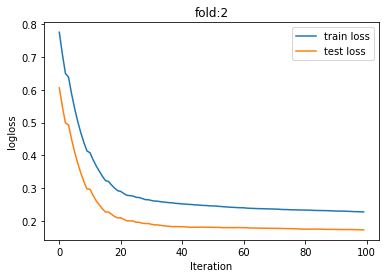

[I 2021-12-27 16:33:15,842] A new study created in memory with name: no-name-7464c74a-8329-41ca-a1cd-cab7812d589d
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.098395:  14%|######4                                      | 1/7 [00:00<00:04,  1.37it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145267	Test's rmse: 0.098395
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.076069:  29%|############8                                | 2/7 [00:01<00:03,  1.28it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133454	Test's rmse: 0.0760688
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.076069:  43%|###################2                         | 3/7 [00:02<00:03,  1.25it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140409	Test's rmse: 0.0965621
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.021516:  57%|#########################7                   | 4/7 [00:03<00:02,  1.26it/s]

Early stopping, best iteration is:
[45]	Train's rmse: 0.171356	Test's rmse: 0.021516
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.021516:  71%|################################1            | 5/7 [00:04<00:01,  1.22it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136988	Test's rmse: 0.0442342
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.021516:  86%|######################################5      | 6/7 [00:04<00:00,  1.24it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.170059	Test's rmse: 0.0224006
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.021516: 100%|#############################################| 7/7 [00:05<00:00,  1.25it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131369	Test's rmse: 0.0560348


num_leaves, val_score: 0.021516:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.021516:   5%|##5                                               | 1/20 [00:00<00:13,  1.45it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.167305	Test's rmse: 0.0221997
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.021273:  10%|#####                                             | 2/20 [00:04<00:46,  2.60s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.168059	Test's rmse: 0.021273
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.021273:  15%|#######5                                          | 3/20 [00:08<00:54,  3.18s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154226	Test's rmse: 0.0302733
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.021273:  20%|##########                                        | 4/20 [00:13<01:05,  4.08s/it]

Early stopping, best iteration is:
[42]	Train's rmse: 0.17089	Test's rmse: 0.021928
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.021273:  25%|############5                                     | 5/20 [00:18<01:04,  4.28s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.168633	Test's rmse: 0.0218531
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.019685:  30%|###############                                   | 6/20 [00:19<00:43,  3.11s/it]

Early stopping, best iteration is:
[44]	Train's rmse: 0.168585	Test's rmse: 0.0196845
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.019685:  35%|#################5                                | 7/20 [00:22<00:38,  2.95s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.168064	Test's rmse: 0.0213414
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.019685:  40%|####################                              | 8/20 [00:25<00:35,  3.00s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154412	Test's rmse: 0.029771
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.019685:  45%|######################5                           | 9/20 [00:34<00:53,  4.85s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154246	Test's rmse: 0.0301401
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.019685:  50%|########################5                        | 10/20 [00:35<00:37,  3.70s/it]

Early stopping, best iteration is:
[45]	Train's rmse: 0.169627	Test's rmse: 0.0204928
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.019685:  55%|##########################9                      | 11/20 [00:37<00:29,  3.22s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.168616	Test's rmse: 0.021482
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.019685:  60%|#############################4                   | 12/20 [00:37<00:18,  2.30s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.209101	Test's rmse: 0.0477316
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.019685:  65%|###############################8                 | 13/20 [00:39<00:15,  2.14s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.1707	Test's rmse: 0.0215332
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.019685:  70%|##################################3              | 14/20 [00:41<00:13,  2.24s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.168672	Test's rmse: 0.0214617
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.019685:  75%|####################################7            | 15/20 [00:42<00:09,  1.93s/it]

Early stopping, best iteration is:
[44]	Train's rmse: 0.170114	Test's rmse: 0.0200508
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.019685:  80%|#######################################2         | 16/20 [00:45<00:08,  2.20s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154348	Test's rmse: 0.0301142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.019685:  85%|#########################################6       | 17/20 [00:46<00:05,  1.67s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156588	Test's rmse: 0.0254975
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.019685:  90%|############################################1    | 18/20 [00:47<00:03,  1.56s/it]

Early stopping, best iteration is:
[46]	Train's rmse: 0.169806	Test's rmse: 0.0202231
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.019685:  95%|##############################################5  | 19/20 [00:49<00:01,  1.76s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154326	Test's rmse: 0.0298431
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.019685: 100%|#################################################| 20/20 [00:50<00:00,  2.53s/it]


Early stopping, best iteration is:
[44]	Train's rmse: 0.170515	Test's rmse: 0.0203722


bagging, val_score: 0.019685:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.019685:  10%|#####3                                               | 1/10 [00:00<00:06,  1.43it/s]

Did not meet early stopping. Best iteration is:
[95]	Train's rmse: 0.186725	Test's rmse: 0.031562
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.019685:  20%|##########6                                          | 2/10 [00:01<00:05,  1.48it/s]

Early stopping, best iteration is:
[45]	Train's rmse: 0.181387	Test's rmse: 0.0253873
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.019685:  30%|###############9                                     | 3/10 [00:02<00:04,  1.46it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.187336	Test's rmse: 0.0335145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.019685:  40%|#####################2                               | 4/10 [00:02<00:04,  1.42it/s]

Early stopping, best iteration is:
[35]	Train's rmse: 0.193415	Test's rmse: 0.0251924
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.019685:  50%|##########################5                          | 5/10 [00:03<00:03,  1.42it/s]

Early stopping, best iteration is:
[35]	Train's rmse: 0.202878	Test's rmse: 0.0257009
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.019685:  60%|###############################8                     | 6/10 [00:04<00:02,  1.38it/s]

Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.188959	Test's rmse: 0.0259501
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.019685:  70%|#####################################                | 7/10 [00:04<00:02,  1.42it/s]

Early stopping, best iteration is:
[35]	Train's rmse: 0.200102	Test's rmse: 0.0280031
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.019685:  80%|##########################################4          | 8/10 [00:05<00:01,  1.27it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174352	Test's rmse: 0.030369
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.019685:  90%|###############################################7     | 9/10 [00:06<00:00,  1.27it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156524	Test's rmse: 0.027147
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.019685: 100%|####################################################| 10/10 [00:07<00:00,  1.37it/s]


Early stopping, best iteration is:
[36]	Train's rmse: 0.197126	Test's rmse: 0.0326291


feature_fraction_stage2, val_score: 0.019685:   0%|                                              | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.019685:  33%|############6                         | 1/3 [00:00<00:01,  1.36it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.174536	Test's rmse: 0.0219121
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.019685:  67%|#########################3            | 2/3 [00:01<00:00,  1.44it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.168585	Test's rmse: 0.0196845
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.019685: 100%|######################################| 3/3 [00:02<00:00,  1.39it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152238	Test's rmse: 0.0294971


regularization_factors, val_score: 0.019685:   0%|                                              | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.019685:   5%|#9                                    | 1/20 [00:00<00:14,  1.28it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154547	Test's rmse: 0.0291259
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.019685:  10%|###8                                  | 2/20 [00:01<00:14,  1.23it/s]

Early stopping, best iteration is:
[45]	Train's rmse: 0.169748	Test's rmse: 0.0200137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

regularization_factors, val_score: 0.019685:  15%|#####7                                | 3/20 [00:02<00:15,  1.13it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154779	Test's rmse: 0.0287854
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.019685:  20%|#######6                              | 4/20 [00:03<00:13,  1.16it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.158152	Test's rmse: 0.0254324
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.019685:  25%|#########5                            | 5/20 [00:04<00:12,  1.17it/s]

Early stopping, best iteration is:
[45]	Train's rmse: 0.170018	Test's rmse: 0.0208387
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.019685:  30%|###########4                          | 6/20 [00:05<00:12,  1.16it/s]

Early stopping, best iteration is:
[45]	Train's rmse: 0.17174	Test's rmse: 0.0221549
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.019685:  35%|#############3                        | 7/20 [00:05<00:11,  1.17it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.174704	Test's rmse: 0.0206907
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.019685:  40%|###############2                      | 8/20 [00:06<00:10,  1.17it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.168585	Test's rmse: 0.0196845
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.019685:  45%|#################1                    | 9/20 [00:07<00:08,  1.22it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.173515	Test's rmse: 0.0199549
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.019685:  50%|##################5                  | 10/20 [00:08<00:08,  1.22it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154568	Test's rmse: 0.0282076
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.019685:  55%|####################3                | 11/20 [00:09<00:07,  1.26it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.168585	Test's rmse: 0.0196845
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.019685:  60%|######################2              | 12/20 [00:09<00:06,  1.30it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.168585	Test's rmse: 0.0196845
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.019685:  65%|########################             | 13/20 [00:10<00:05,  1.35it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.168585	Test's rmse: 0.0196845
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.019685:  70%|#########################9           | 14/20 [00:11<00:04,  1.33it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15466	Test's rmse: 0.0283184
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.019685:  75%|###########################7         | 15/20 [00:11<00:03,  1.43it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.168585	Test's rmse: 0.0196845
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.019685:  80%|#############################6       | 16/20 [00:12<00:02,  1.52it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154661	Test's rmse: 0.0283179
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.019685:  85%|###############################4     | 17/20 [00:12<00:01,  1.62it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.168585	Test's rmse: 0.0196845
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.019685:  90%|#################################3   | 18/20 [00:13<00:01,  1.66it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154632	Test's rmse: 0.0283435
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

regularization_factors, val_score: 0.019685:  90%|#################################3   | 18/20 [00:13<00:01,  1.66it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

regularization_factors, val_score: 0.019685:  95%|###################################1 | 19/20 [00:13<00:00,  1.88it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.019685: 100%|#####################################| 20/20 [00:14<00:00,  1.38it/s]


Early stopping, best iteration is:
[44]	Train's rmse: 0.168585	Test's rmse: 0.0196845


min_data_in_leaf, val_score: 0.019685:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.019685:  20%|#########                                    | 1/5 [00:00<00:01,  2.14it/s]

Early stopping, best iteration is:
[41]	Train's rmse: 0.107189	Test's rmse: 0.0241533
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.019685:  40%|##################                           | 2/5 [00:00<00:01,  2.03it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.258625	Test's rmse: 0.0565003
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.019685:  60%|###########################                  | 3/5 [00:01<00:00,  2.12it/s]

Early stopping, best iteration is:
[27]	Train's rmse: 0.320872	Test's rmse: 0.0921468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.019685:  80%|####################################         | 4/5 [00:01<00:00,  2.09it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.0507689	Test's rmse: 0.0266891
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.019685: 100%|#############################################| 5/5 [00:02<00:00,  2.07it/s]

Early stopping, best iteration is:
[42]	Train's rmse: 0.180084	Test's rmse: 0.0304209


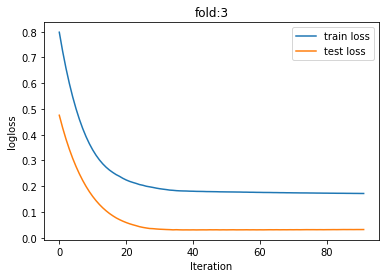

[I 2021-12-27 16:34:38,655] A new study created in memory with name: no-name-022235a3-a8d2-4ebe-8945-c9c9241a0679
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.364145:  14%|######4                                      | 1/7 [00:00<00:04,  1.24it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.153791	Test's rmse: 0.364145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.361661:  29%|############8                                | 2/7 [00:01<00:03,  1.35it/s]

Early stopping, best iteration is:
[37]	Train's rmse: 0.155527	Test's rmse: 0.361661
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.361661:  43%|###################2                         | 3/7 [00:02<00:03,  1.31it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.123503	Test's rmse: 0.399484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.361661:  57%|#########################7                   | 4/7 [00:03<00:02,  1.29it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.123402	Test's rmse: 0.387645
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.361661:  71%|################################1            | 5/7 [00:03<00:01,  1.26it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.125217	Test's rmse: 0.382659
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.358623:  86%|######################################5      | 6/7 [00:04<00:00,  1.33it/s]

Early stopping, best iteration is:
[34]	Train's rmse: 0.159544	Test's rmse: 0.358623
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.358623: 100%|#############################################| 7/7 [00:05<00:00,  1.30it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126172	Test's rmse: 0.409226


num_leaves, val_score: 0.358623:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.340161:   5%|##5                                               | 1/20 [00:00<00:05,  3.62it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.15689	Test's rmse: 0.340161
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.340161:  10%|#####                                             | 2/20 [00:02<00:30,  1.69s/it]

Early stopping, best iteration is:
[35]	Train's rmse: 0.15919	Test's rmse: 0.360137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.340161:  15%|#######5                                          | 3/20 [00:03<00:19,  1.12s/it]

Early stopping, best iteration is:
[34]	Train's rmse: 0.159989	Test's rmse: 0.361971
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.340161:  20%|##########                                        | 4/20 [00:06<00:29,  1.83s/it]

Early stopping, best iteration is:
[35]	Train's rmse: 0.159135	Test's rmse: 0.360143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.340161:  25%|############5                                     | 5/20 [00:07<00:25,  1.68s/it]

Early stopping, best iteration is:
[35]	Train's rmse: 0.159208	Test's rmse: 0.36018
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.340161:  30%|###############                                   | 6/20 [00:08<00:20,  1.45s/it]

Early stopping, best iteration is:
[35]	Train's rmse: 0.159223	Test's rmse: 0.36047
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.340161:  35%|#################5                                | 7/20 [00:09<00:14,  1.12s/it]

Early stopping, best iteration is:
[34]	Train's rmse: 0.159544	Test's rmse: 0.358623
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.340161:  40%|####################                              | 8/20 [00:10<00:14,  1.17s/it]

Early stopping, best iteration is:
[35]	Train's rmse: 0.15926	Test's rmse: 0.360518
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.340161:  45%|######################5                           | 9/20 [00:14<00:23,  2.17s/it]

Early stopping, best iteration is:
[35]	Train's rmse: 0.159152	Test's rmse: 0.36013
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.340161:  50%|########################5                        | 10/20 [00:17<00:22,  2.22s/it]

Early stopping, best iteration is:
[35]	Train's rmse: 0.159183	Test's rmse: 0.360162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.340161:  55%|##########################9                      | 11/20 [00:21<00:26,  2.91s/it]

Early stopping, best iteration is:
[31]	Train's rmse: 0.162916	Test's rmse: 0.362757
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.340161:  60%|#############################4                   | 12/20 [00:21<00:16,  2.11s/it]

Early stopping, best iteration is:
[37]	Train's rmse: 0.159301	Test's rmse: 0.34501
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.340161:  65%|###############################8                 | 13/20 [00:22<00:11,  1.59s/it]

Early stopping, best iteration is:
[32]	Train's rmse: 0.160031	Test's rmse: 0.350474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.340161:  70%|##################################3              | 14/20 [00:23<00:08,  1.46s/it]

Early stopping, best iteration is:
[34]	Train's rmse: 0.160184	Test's rmse: 0.363516
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.340161:  75%|####################################7            | 15/20 [00:25<00:08,  1.76s/it]

Early stopping, best iteration is:
[35]	Train's rmse: 0.159155	Test's rmse: 0.360176
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.340161:  80%|#######################################2         | 16/20 [00:26<00:05,  1.31s/it]

Early stopping, best iteration is:
[37]	Train's rmse: 0.159301	Test's rmse: 0.34501
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.340161:  85%|#########################################6       | 17/20 [00:27<00:04,  1.40s/it]

Early stopping, best iteration is:
[34]	Train's rmse: 0.160143	Test's rmse: 0.363562
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.340161:  90%|############################################1    | 18/20 [00:31<00:04,  2.14s/it]

Early stopping, best iteration is:
[35]	Train's rmse: 0.159138	Test's rmse: 0.36015
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.340161:  95%|##############################################5  | 19/20 [00:32<00:01,  1.86s/it]

Early stopping, best iteration is:
[35]	Train's rmse: 0.159007	Test's rmse: 0.359288
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.197686	Test's rmse: 0.331686


bagging, val_score: 0.331686:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.321775:  20%|##########6                                          | 2/10 [00:00<00:01,  4.12it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.197317	Test's rmse: 0.327409
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198647	Test's rmse: 0.321775


[I 2021-12-27 16:35:17,578] Trial 28 finished with value: 0.3217745358366259 and parameters: {'bagging_fraction': 0.5727013960059262, 'bagging_freq': 5}. Best is trial 28 with value: 0.3217745358366259.
bagging, val_score: 0.321775:  20%|##########6                                          | 2/10 [00:00<00:01,  4.12it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.321775:  30%|###############9                                     | 3/10 [00:00<00:01,  3.75it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.197441	Test's rmse: 0.327404
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.198145	Test's rmse: 0.330403


bagging, val_score: 0.321775:  40%|#####################2                               | 4/10 [00:00<00:01,  4.23it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.198132	Test's rmse: 0.323833


bagging, val_score: 0.321775:  60%|###############################8                     | 6/10 [00:01<00:00,  4.55it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.197233	Test's rmse: 0.327776
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001392 seconds.
You can set `force_col_wise=true` to remove the overhead.


bagging, val_score: 0.321775:  70%|#####################################                | 7/10 [00:01<00:00,  4.74it/s]

[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.198215	Test's rmse: 0.327576
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20


bagging, val_score: 0.321775:  80%|##########################################4          | 8/10 [00:01<00:00,  4.90it/s]

[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[90]	Train's rmse: 0.199004	Test's rmse: 0.322861
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.197418	Test's rmse: 0.330193


bagging, val_score: 0.321775: 100%|####################################################| 10/10 [00:02<00:00,  4.35it/s]


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[97]	Train's rmse: 0.198717	Test's rmse: 0.325809


feature_fraction_stage2, val_score: 0.321775:   0%|                                              | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001468 seconds.
You can set `force_col_wise=true` to remove the overhead.


feature_fraction_stage2, val_score: 0.321775:  17%|######3                               | 1/6 [00:00<00:00,  5.82it/s]

[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[91]	Train's rmse: 0.198153	Test's rmse: 0.323532
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651


feature_fraction_stage2, val_score: 0.321775:  33%|############6                         | 2/6 [00:00<00:00,  5.54it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[92]	Train's rmse: 0.198202	Test's rmse: 0.322762
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001372 seconds.
You can set `force_col_wise=true` to remove the overhead.


feature_fraction_stage2, val_score: 0.321775:  50%|###################                   | 3/6 [00:00<00:00,  4.99it/s]

[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[97]	Train's rmse: 0.198672	Test's rmse: 0.322906


feature_fraction_stage2, val_score: 0.321775:  67%|#########################3            | 4/6 [00:00<00:00,  5.16it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198647	Test's rmse: 0.321775
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.321775:  83%|###############################6      | 5/6 [00:01<00:00,  4.44it/s]

Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198647	Test's rmse: 0.321775
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.321775: 100%|######################################| 6/6 [00:01<00:00,  4.78it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.19867	Test's rmse: 0.32464


regularization_factors, val_score: 0.321775:   0%|                                              | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198631	Test's rmse: 0.321815


regularization_factors, val_score: 0.321775:   5%|#9                                    | 1/20 [00:00<00:03,  4.99it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.321775:  10%|###8                                  | 2/20 [00:00<00:03,  4.77it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.200088	Test's rmse: 0.328999
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.321775:  15%|#####7                                | 3/20 [00:00<00:03,  4.57it/s]

Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198647	Test's rmse: 0.321775
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.321775:  20%|#######6                              | 4/20 [00:00<00:03,  4.40it/s]

Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198882	Test's rmse: 0.323142
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.321775:  25%|#########5                            | 5/20 [00:01<00:03,  3.97it/s]

Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198644	Test's rmse: 0.322187
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.321775:  30%|###########4                          | 6/20 [00:01<00:03,  4.16it/s]

Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198647	Test's rmse: 0.321775
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.321775:  35%|#############3                        | 7/20 [00:01<00:03,  4.31it/s]

Did not meet early stopping. Best iteration is:
[92]	Train's rmse: 0.198841	Test's rmse: 0.323473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.321775:  40%|###############2                      | 8/20 [00:01<00:02,  4.38it/s]

Did not meet early stopping. Best iteration is:
[94]	Train's rmse: 0.19877	Test's rmse: 0.321819
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198722	Test's rmse: 0.321271


regularization_factors, val_score: 0.321271:  45%|#################1                    | 9/20 [00:02<00:02,  4.68it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651


regularization_factors, val_score: 0.321271:  50%|##################5                  | 10/20 [00:02<00:02,  3.51it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198647	Test's rmse: 0.32178


regularization_factors, val_score: 0.321271:  55%|####################3                | 11/20 [00:02<00:02,  3.87it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198647	Test's rmse: 0.321776
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.321271:  60%|######################2              | 12/20 [00:02<00:01,  4.14it/s]

Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198647	Test's rmse: 0.321775
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198647	Test's rmse: 0.321775


regularization_factors, val_score: 0.321271:  65%|########################             | 13/20 [00:03<00:01,  4.35it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.321271:  70%|#########################9           | 14/20 [00:03<00:01,  4.30it/s]

Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198647	Test's rmse: 0.321775
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.321271:  75%|###########################7         | 15/20 [00:03<00:01,  4.33it/s]

Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198646	Test's rmse: 0.321786
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.321271:  80%|#############################6       | 16/20 [00:03<00:00,  4.59it/s]

Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198647	Test's rmse: 0.321775
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.321271:  85%|###############################4     | 17/20 [00:03<00:00,  4.48it/s]

Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198647	Test's rmse: 0.321775
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198647	Test's rmse: 0.321776


regularization_factors, val_score: 0.321271:  90%|#################################3   | 18/20 [00:04<00:00,  4.57it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198646	Test's rmse: 0.32179


regularization_factors, val_score: 0.321271: 100%|#####################################| 20/20 [00:04<00:00,  4.31it/s]


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198647	Test's rmse: 0.321775


min_data_in_leaf, val_score: 0.321271:  20%|#########                                    | 1/5 [00:00<00:01,  4.00it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.198128	Test's rmse: 0.321952


[I 2021-12-27 16:35:25,512] Trial 63 finished with value: 0.3219522292966598 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.3219522292966598.
min_data_in_leaf, val_score: 0.321271:  40%|##################                           | 2/5 [00:00<00:00,  4.32it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.197898	Test's rmse: 0.322732
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.321271:  60%|###########################                  | 3/5 [00:00<00:00,  3.88it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.241503	Test's rmse: 0.421091
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.321271:  80%|####################################         | 4/5 [00:01<00:00,  3.76it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.292473	Test's rmse: 0.517238
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.321271: 100%|#############################################| 5/5 [00:01<00:00,  3.84it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.200564	Test's rmse: 0.326529


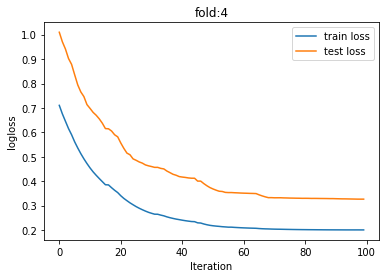

RMSE: [0.3110330750516519, 0.09400562151235992, 0.13227288476058482, 0.019684537458421882, 0.3212707144989054]
RMSE: 0.17565336665638479


In [8]:
y_train_dropna = y_train_dropna.reset_index(drop=True)

gkf = GroupKFold(n_splits=5)

groups = X_train_dropna["Genre"]

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': 'rmse',             # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'seed': SEED                   # シード値
          }

best_params, history = {}, []

cv_result_dropna = []

for fold, (train_index, test_index) in enumerate(gkf.split(X_train_dropna, y_train_dropna, groups)):
    X_train_gkf, X_test_gkf = X_train_dropna.iloc[train_index], X_train_dropna.iloc[test_index]
    y_train_gkf, y_test_gkf = y_train_dropna.iloc[train_index], y_train_dropna.iloc[test_index]

    # 学習、推論
    lgb_train = lgb.Dataset(X_train_gkf, y_train_gkf)
    lgb_test = lgb.Dataset(X_test_gkf, y_test_gkf, reference=lgb_train)

    lgb_results = {}                                    # 学習の履歴を入れる入物

    model = lgb.train(
                    params,                    # ハイパーパラメータをセット
                    lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    verbose_eval=-1,                  # ログを最後の1つだけ表示
                    )  
    
    best_params = model.params

    # 損失推移を表示
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')

    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    y_pred = model.predict(X_test_gkf, num_iteration=model.best_iteration)

    # 評価
    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result_dropna.append(rmse)

print("RMSE:", cv_result_dropna)
print("RMSE:", np.mean(cv_result_dropna))

## IsolationForest による外れ値除去

In [9]:
# IsolationForest は 正常=1 異常=-1 として結果を返す
model = IsolationForest(
                random_state=SEED
                )

In [10]:
train_anomaly = model.fit_predict(X_train_dropna)

test_anomaly = model.fit_predict(X_test_dropna)

In [11]:
print(np.mean(abs(model.score_samples(X_train_dropna))))

0.5551405831072379


In [12]:
X_train_normal = X_train_dropna[train_anomaly == 1]
X_train_anomaly = X_train_dropna[train_anomaly == -1]

# テスト
assert len(X_train_dropna) == (len(X_train_normal) + len(X_train_anomaly))


X_test_normal = X_test_dropna[test_anomaly == 1]
X_test_anomaly = X_test_dropna[test_anomaly == -1]

# テスト
assert len(X_test_dropna) == (len(X_test_normal) + len(X_test_anomaly))

In [13]:
y_train_normal = y_train_dropna[train_anomaly == 1]

y_test_normal = y_test_dropna[test_anomaly == 1]

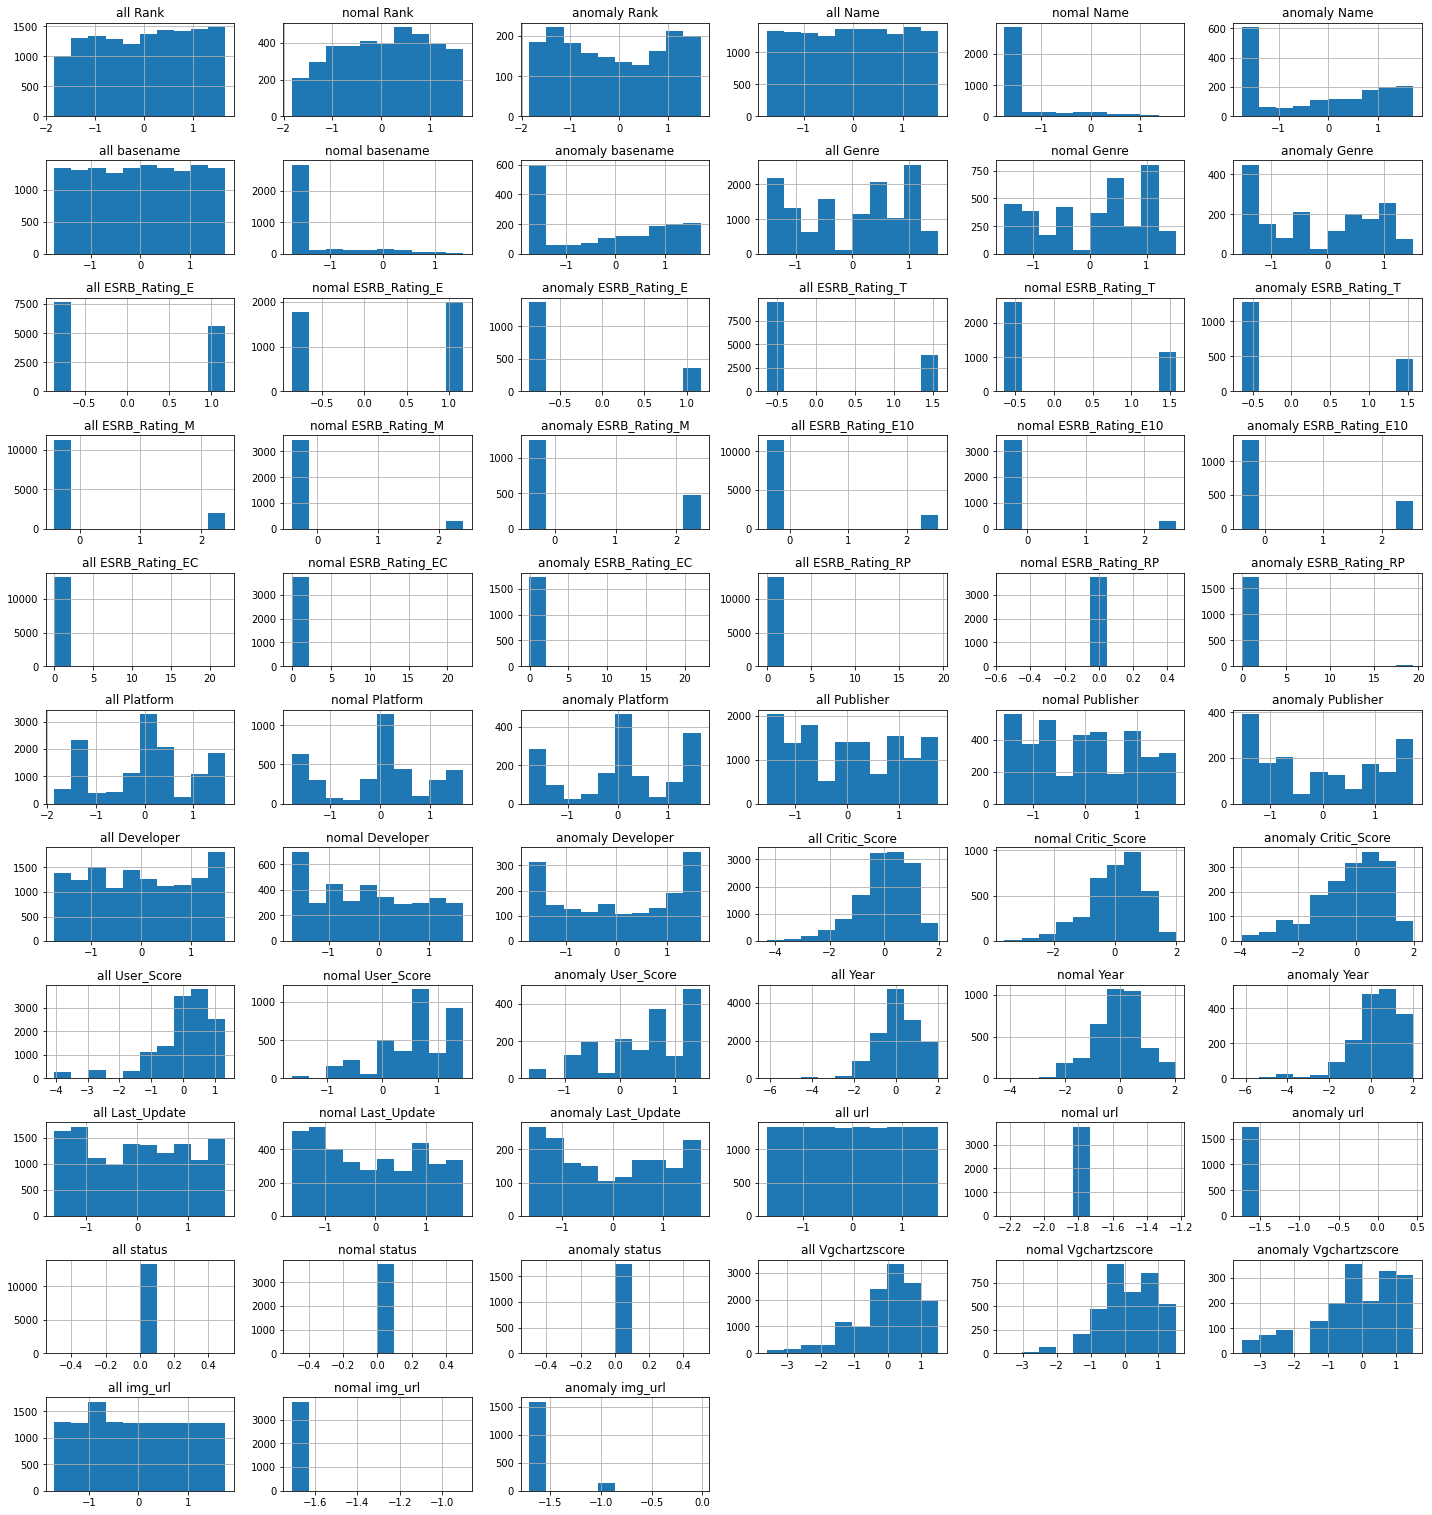

In [14]:
plt.figure(figsize=(20, 40))
for i, column in enumerate(X_test_normal.columns):

    plt.subplot(len(X_test_dropna.columns), 6 , i*3+1)
    plt.title("all " + column)
    X_train_dropna[column].hist();

    plt.subplot(len(X_test_normal.columns), 6,  i*3+2)
    plt.title("nomal " + column)
    X_test_normal[column].hist();

    plt.subplot(len(X_test_anomaly.columns), 6 , i*3+3)
    plt.title("anomaly " + column)
    X_test_anomaly[column].hist();

plt.tight_layout()

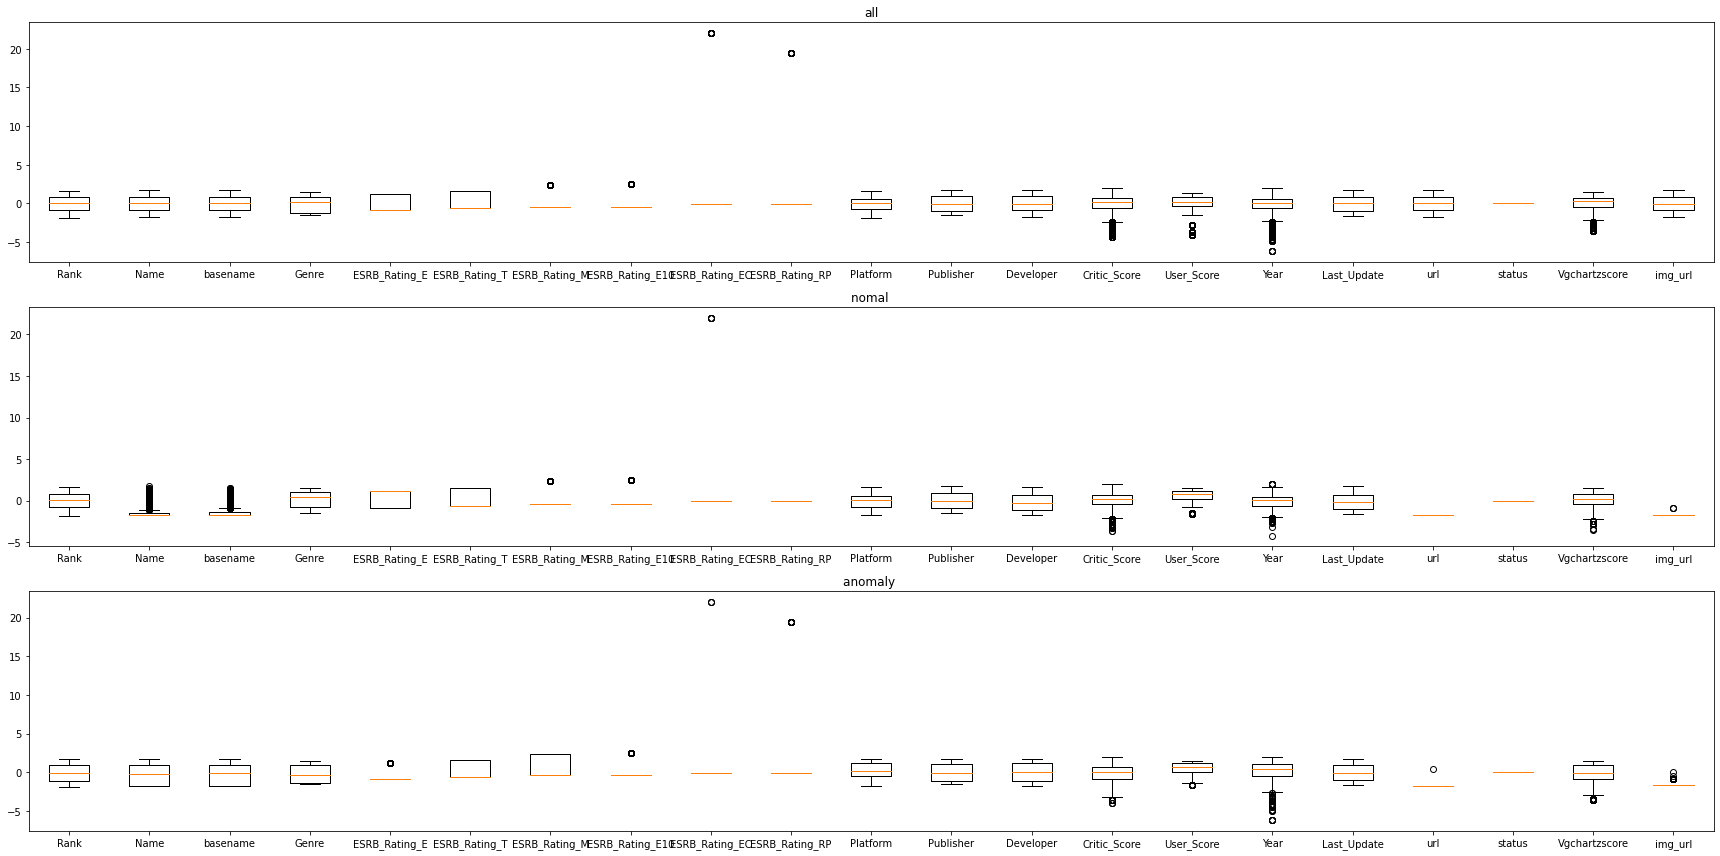

In [15]:
plt.figure(figsize=(24, 12))

plt.subplot(3, 1 , 1)
plt.title("all")
plt.boxplot(
    X_train_dropna.values,
    labels=X_test_dropna.columns
    );

plt.subplot(3, 1 , 2)
plt.title("nomal ")
plt.boxplot(
    X_test_normal.values,
    labels=X_test_normal.columns
    );

plt.subplot(3, 1 , 3)
plt.title("anomaly ")
plt.boxplot(
    X_test_anomaly.values,
    labels=X_test_anomaly.columns
    );

plt.tight_layout()

In [16]:
X_train_normal = X_train_normal.reset_index(drop=True)
y_train_normal = y_train_normal.reset_index(drop=True)

[I 2021-12-27 16:35:46,697] A new study created in memory with name: no-name-842b2633-6706-4c15-8823-677c01fcf9ee
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.224504:  14%|######4                                      | 1/7 [00:00<00:04,  1.40it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0719009	Test's rmse: 0.224504
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.213829:  29%|############8                                | 2/7 [00:01<00:03,  1.38it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0667033	Test's rmse: 0.213829
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.199439:  43%|###################2                         | 3/7 [00:02<00:02,  1.49it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.0812003	Test's rmse: 0.199439
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.199439:  57%|#########################7                   | 4/7 [00:02<00:02,  1.45it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0671605	Test's rmse: 0.202046
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.199439:  71%|################################1            | 5/7 [00:03<00:01,  1.37it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0714446	Test's rmse: 0.225824
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.199439:  86%|######################################5      | 6/7 [00:04<00:00,  1.28it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.0833021	Test's rmse: 0.200839
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.199439: 100%|#############################################| 7/7 [00:05<00:00,  1.35it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.065041	Test's rmse: 0.207078


num_leaves, val_score: 0.199439:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

num_leaves, val_score: 0.199439:   5%|##5                                               | 1/20 [00:03<00:58,  3.09s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0796287	Test's rmse: 0.199492
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

num_leaves, val_score: 0.199439:  10%|#####                                             | 2/20 [00:05<00:52,  2.92s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0796287	Test's rmse: 0.199492
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

num_leaves, val_score: 0.199439:  15%|#######5                                          | 3/20 [00:08<00:43,  2.56s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0796288	Test's rmse: 0.199492
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.199439:  20%|##########                                        | 4/20 [00:08<00:27,  1.72s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0748175	Test's rmse: 0.199495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

num_leaves, val_score: 0.199439:  25%|############5                                     | 5/20 [00:10<00:28,  1.90s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0796287	Test's rmse: 0.199492
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.199439:  30%|###############                                   | 6/20 [00:11<00:19,  1.38s/it]

Early stopping, best iteration is:
[36]	Train's rmse: 0.0810395	Test's rmse: 0.199614
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.199439:  35%|#################5                                | 7/20 [00:12<00:16,  1.25s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0796673	Test's rmse: 0.19949
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

num_leaves, val_score: 0.199439:  40%|####################                              | 8/20 [00:14<00:20,  1.68s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0796291	Test's rmse: 0.199492
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

num_leaves, val_score: 0.199439:  45%|######################5                           | 9/20 [00:16<00:20,  1.87s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0796292	Test's rmse: 0.199492
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

num_leaves, val_score: 0.199439:  50%|########################5                        | 10/20 [00:20<00:22,  2.28s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0796287	Test's rmse: 0.199492
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.199439:  55%|##########################9                      | 11/20 [00:21<00:18,  2.02s/it]

Early stopping, best iteration is:
[37]	Train's rmse: 0.0800977	Test's rmse: 0.19959
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.199439:  60%|#############################4                   | 12/20 [00:23<00:15,  1.90s/it]

Early stopping, best iteration is:
[38]	Train's rmse: 0.0799048	Test's rmse: 0.199566
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.199439:  65%|###############################8                 | 13/20 [00:24<00:13,  1.87s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0796324	Test's rmse: 0.199492
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.199439:  70%|##################################3              | 14/20 [00:27<00:12,  2.06s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0796306	Test's rmse: 0.199492
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.199439:  75%|####################################7            | 15/20 [00:28<00:08,  1.63s/it]

Early stopping, best iteration is:
[43]	Train's rmse: 0.0793473	Test's rmse: 0.199622
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.199439:  80%|#######################################2         | 16/20 [00:29<00:06,  1.59s/it]

Early stopping, best iteration is:
[37]	Train's rmse: 0.0801008	Test's rmse: 0.199591
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

num_leaves, val_score: 0.199439:  85%|#########################################6       | 17/20 [00:34<00:07,  2.60s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0796288	Test's rmse: 0.199492
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.199439:  90%|############################################1    | 18/20 [00:38<00:06,  3.10s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0796301	Test's rmse: 0.199492
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

num_leaves, val_score: 0.199439:  95%|##############################################5  | 19/20 [00:43<00:03,  3.70s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[39]	Train's rmse: 0.0796287	Test's rmse: 0.199492
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.199439: 100%|#################################################| 20/20 [00:44<00:00,  2.21s/it]


Early stopping, best iteration is:
[40]	Train's rmse: 0.0842219	Test's rmse: 0.200245


bagging, val_score: 0.199439:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.199439:  10%|#####3                                               | 1/10 [00:01<00:10,  1.13s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0974467	Test's rmse: 0.223562
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.199439:  20%|##########6                                          | 2/10 [00:02<00:09,  1.17s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0865518	Test's rmse: 0.213598
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.199439:  30%|###############9                                     | 3/10 [00:03<00:07,  1.12s/it]

Early stopping, best iteration is:
[45]	Train's rmse: 0.128098	Test's rmse: 0.242295
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.199439:  40%|#####################2                               | 4/10 [00:04<00:06,  1.09s/it]

Early stopping, best iteration is:
[49]	Train's rmse: 0.0774956	Test's rmse: 0.199948
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.199439:  50%|##########################5                          | 5/10 [00:05<00:05,  1.00s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0832746	Test's rmse: 0.207413
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.199439:  60%|###############################8                     | 6/10 [00:06<00:03,  1.04it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.127519	Test's rmse: 0.242395
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.199439:  70%|#####################################                | 7/10 [00:07<00:02,  1.08it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.0780883	Test's rmse: 0.201457
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.199439:  80%|##########################################4          | 8/10 [00:07<00:01,  1.20it/s]

Early stopping, best iteration is:
[31]	Train's rmse: 0.0862094	Test's rmse: 0.202294
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.199312:  90%|###############################################7     | 9/10 [00:08<00:00,  1.26it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0794212	Test's rmse: 0.199312
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.199312: 100%|####################################################| 10/10 [00:09<00:00,  1.09it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.122791	Test's rmse: 0.245819


feature_fraction_stage2, val_score: 0.199312:   0%|                                              | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.199312:  33%|############6                         | 1/3 [00:00<00:01,  1.35it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0794212	Test's rmse: 0.199312
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.199312:  67%|#########################3            | 2/3 [00:01<00:00,  1.35it/s]

Early stopping, best iteration is:
[41]	Train's rmse: 0.0786995	Test's rmse: 0.199415
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.199312: 100%|######################################| 3/3 [00:02<00:00,  1.34it/s]


Early stopping, best iteration is:
[41]	Train's rmse: 0.0792917	Test's rmse: 0.200073


regularization_factors, val_score: 0.199312:   0%|                                              | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

regularization_factors, val_score: 0.199033:   5%|#9                                    | 1/20 [00:00<00:13,  1.41it/s]

Early stopping, best iteration is:
[41]	Train's rmse: 0.0791656	Test's rmse: 0.199033
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.199033:  10%|###8                                  | 2/20 [00:01<00:15,  1.15it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0794213	Test's rmse: 0.199312
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

regularization_factors, val_score: 0.199033:  15%|#####7                                | 3/20 [00:02<00:11,  1.54it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0800392	Test's rmse: 0.19943
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001376 seconds.
You can set `force_col_wise=true` to remove 

regularization_factors, val_score: 0.199033:  20%|#######6                              | 4/20 [00:02<00:11,  1.35it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0796281	Test's rmse: 0.199314
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

regularization_factors, val_score: 0.199033:  25%|#########5                            | 5/20 [00:03<00:10,  1.41it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[42]	Train's rmse: 0.0789508	Test's rmse: 0.201057
[LightGBM] [Wa

regularization_factors, val_score: 0.199033:  30%|###########4                          | 6/20 [00:04<00:11,  1.23it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0794213	Test's rmse: 0.199312
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

regularization_factors, val_score: 0.199033:  35%|#############3                        | 7/20 [00:05<00:10,  1.27it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0794362	Test's rmse: 0.199483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

regularization_factors, val_score: 0.199033:  40%|###############2                      | 8/20 [00:05<00:08,  1.36it/s]

Early stopping, best iteration is:
[42]	Train's rmse: 0.0795496	Test's rmse: 0.199895
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.199033:  45%|#################1                    | 9/20 [00:06<00:07,  1.38it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.079459	Test's rmse: 0.199343
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

regularization_factors, val_score: 0.199033:  50%|##################5                  | 10/20 [00:06<00:05,  1.72it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

regularization_factors, val_score: 0.199033:  55%|####################3                | 11/20 [00:07<00:05,  1.66it/s]

Early stopping, best iteration is:
[38]	Train's rmse: 0.0799649	Test's rmse: 0.199365
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.199033:  60%|######################2              | 12/20 [00:08<00:05,  1.59it/s]

Early stopping, best iteration is:
[38]	Train's rmse: 0.0799755	Test's rmse: 0.199353
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.199033:  65%|########################             | 13/20 [00:08<00:04,  1.56it/s]

Early stopping, best iteration is:
[38]	Train's rmse: 0.0799753	Test's rmse: 0.199353
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


regularization_factors, val_score: 0.199033:  70%|#########################9           | 14/20 [00:09<00:03,  1.53it/s]

Early stopping, best iteration is:
[30]	Train's rmse: 0.0847808	Test's rmse: 0.19962
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.199033:  75%|###########################7         | 15/20 [00:10<00:03,  1.48it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.073785	Test's rmse: 0.200486
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.199033:  80%|#############################6       | 16/20 [00:11<00:02,  1.47it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0794214	Test's rmse: 0.199312
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

regularization_factors, val_score: 0.199033:  85%|###############################4     | 17/20 [00:11<00:01,  1.59it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

regularization_factors, val_score: 0.199033:  90%|#################################3   | 18/20 [00:12<00:01,  1.57it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0794278	Test's rmse: 0.199313
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.199033:  95%|###################################1 | 19/20 [00:12<00:00,  1.48it/s]

Early stopping, best iteration is:
[38]	Train's rmse: 0.0799746	Test's rmse: 0.19936
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

regularization_factors, val_score: 0.199033: 100%|#####################################| 20/20 [00:13<00:00,  1.48it/s]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[40]	Train's rmse: 0.0790112	Test's rmse: 0.19993


min_data_in_leaf, val_score: 0.199033:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

min_data_in_leaf, val_score: 0.199033:  20%|#########                                    | 1/5 [00:00<00:02,  1.61it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0767637	Test's rmse: 0.203374
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

min_data_in_leaf, val_score: 0.199033:  40%|##################                           | 2/5 [00:01<00:01,  1.81it/s]

Early stopping, best iteration is:
[29]	Train's rmse: 0.0735326	Test's rmse: 0.208483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

min_data_in_leaf, val_score: 0.199033:  60%|###########################                  | 3/5 [00:01<00:01,  1.81it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.0466469	Test's rmse: 0.216524
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 20
[LightGBM] [Info] Start training from score 0.286704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

min_data_in_leaf, val_score: 0.199033:  80%|####################################         | 4/5 [00:02<00:00,  2.13it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

min_data_in_leaf, val_score: 0.199033: 100%|#############################################| 5/5 [00:02<00:00,  2.09it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

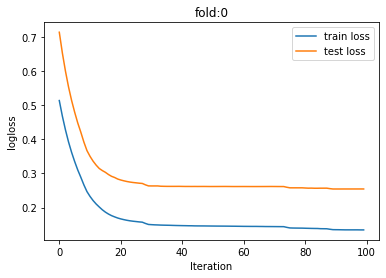

[I 2021-12-27 16:37:03,734] A new study created in memory with name: no-name-8eb5933a-625c-4878-8c84-35218c15045c
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.148537:  14%|######4                                      | 1/7 [00:00<00:04,  1.35it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0805074	Test's rmse: 0.148537
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.148537:  29%|############8                                | 2/7 [00:01<00:03,  1.51it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0794922	Test's rmse: 0.154004
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.148537:  43%|###################2                         | 3/7 [00:01<00:02,  1.86it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0785781	Test's rmse: 0.166507
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.148537:  57%|#########################7                   | 4/7 [00:02<00:01,  1.97it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0809096	Test's rmse: 0.177633
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.148537:  71%|################################1            | 5/7 [00:02<00:00,  2.12it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0821047	Test's rmse: 0.180827
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.143152:  86%|######################################5      | 6/7 [00:03<00:00,  2.17it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.0948721	Test's rmse: 0.143152
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.142850: 100%|#############################################| 7/7 [00:03<00:00,  1.99it/s]


Early stopping, best iteration is:
[48]	Train's rmse: 0.0950374	Test's rmse: 0.14285


num_leaves, val_score: 0.142850:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.142095:   5%|##5                                               | 1/20 [00:01<00:30,  1.61s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.0947102	Test's rmse: 0.142095
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

num_leaves, val_score: 0.142095:  10%|#####                                             | 2/20 [00:08<01:20,  4.45s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.0946025	Test's rmse: 0.142348
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.142095:  15%|#######5                                          | 3/20 [00:11<01:06,  3.88s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.0951882	Test's rmse: 0.142716
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.142095:  20%|##########                                        | 4/20 [00:14<00:56,  3.56s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.0946961	Test's rmse: 0.14222
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

num_leaves, val_score: 0.142095:  25%|############5                                     | 5/20 [00:17<00:50,  3.38s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.0947006	Test's rmse: 0.142169
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.142095:  30%|###############                                   | 6/20 [00:20<00:43,  3.13s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.0946146	Test's rmse: 0.142282
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

num_leaves, val_score: 0.142095:  35%|#################5                                | 7/20 [00:23<00:41,  3.20s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0834803	Test's rmse: 0.143583
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

num_leaves, val_score: 0.142095:  40%|####################                              | 8/20 [00:27<00:40,  3.33s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.0946649	Test's rmse: 0.142195
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.142095:  45%|######################5                           | 9/20 [00:29<00:33,  3.02s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.0951554	Test's rmse: 0.142824
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.142095:  50%|########################5                        | 10/20 [00:32<00:29,  2.98s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.0947098	Test's rmse: 0.142136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.142095:  55%|##########################9                      | 11/20 [00:32<00:20,  2.29s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0847147	Test's rmse: 0.144228
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.142095:  60%|#############################4                   | 12/20 [00:34<00:16,  2.04s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.0946549	Test's rmse: 0.142409
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.142095:  65%|###############################8                 | 13/20 [00:36<00:13,  1.91s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0834573	Test's rmse: 0.144368
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

num_leaves, val_score: 0.142095:  70%|##################################3              | 14/20 [00:39<00:15,  2.52s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.0946227	Test's rmse: 0.142389
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

num_leaves, val_score: 0.142095:  75%|####################################7            | 15/20 [00:43<00:13,  2.73s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.0947127	Test's rmse: 0.142111
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.142095:  80%|#######################################2         | 16/20 [00:45<00:10,  2.54s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.0949338	Test's rmse: 0.142681
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

num_leaves, val_score: 0.142095:  85%|#########################################6       | 17/20 [00:50<00:09,  3.27s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.0947018	Test's rmse: 0.142203
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.142095:  90%|############################################1    | 18/20 [00:51<00:05,  2.53s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.0949413	Test's rmse: 0.142152
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

num_leaves, val_score: 0.142095:  95%|##############################################5  | 19/20 [00:55<00:03,  3.07s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.094666	Test's rmse: 0.142197
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

num_leaves, val_score: 0.141946: 100%|#################################################| 20/20 [01:00<00:00,  3.03s/it]


Early stopping, best iteration is:
[48]	Train's rmse: 0.0945929	Test's rmse: 0.141946


bagging, val_score: 0.141946:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

bagging, val_score: 0.141946:  10%|#####3                                               | 1/10 [00:02<00:19,  2.15s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

bagging, val_score: 0.141946:  20%|##########6                                          | 2/10 [00:03<00:14,  1.84s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126067	Test's rmse: 0.195181
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001217 seconds.
You can set `force_col_wise=true` to remove 

bagging, val_score: 0.141946:  30%|###############9                                     | 3/10 [00:06<00:14,  2.12s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0822078	Test's rmse: 0.14586
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

bagging, val_score: 0.141946:  40%|#####################2                               | 4/10 [00:09<00:16,  2.75s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0828887	Test's rmse: 0.146055
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

bagging, val_score: 0.141946:  50%|##########################5                          | 5/10 [00:12<00:13,  2.65s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.120638	Test's rmse: 0.197917
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

bagging, val_score: 0.141946:  60%|###############################8                     | 6/10 [00:14<00:09,  2.36s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.124196	Test's rmse: 0.192242
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

bagging, val_score: 0.141946:  70%|#####################################                | 7/10 [00:17<00:08,  2.71s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

bagging, val_score: 0.141946:  80%|##########################################4          | 8/10 [00:21<00:06,  3.07s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0827566	Test's rmse: 0.143045
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

bagging, val_score: 0.141946:  80%|##########################################4          | 8/10 [00:25<00:06,  3.07s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0879464	Test's rmse: 0.152247


bagging, val_score: 0.141946:  90%|###############################################7     | 9/10 [00:25<00:03,  3.51s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

bagging, val_score: 0.141946:  90%|###############################################7     | 9/10 [00:29<00:03,  3.51s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0910662	Test's rmse: 0.149656


feature_fraction_stage2, val_score: 0.141946:   0%|                                              | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


feature_fraction_stage2, val_score: 0.141946:  17%|######3                               | 1/6 [00:03<00:17,  3.56s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0796451	Test's rmse: 0.150552
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


feature_fraction_stage2, val_score: 0.141946:  33%|############6                         | 2/6 [00:07<00:15,  3.96s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0808601	Test's rmse: 0.15002
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

feature_fraction_stage2, val_score: 0.141946:  50%|###################                   | 3/6 [00:12<00:12,  4.18s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.0945929	Test's rmse: 0.141946
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

feature_fraction_stage2, val_score: 0.141946:  67%|#########################3            | 4/6 [00:16<00:08,  4.11s/it]

Early stopping, best iteration is:
[49]	Train's rmse: 0.0948411	Test's rmse: 0.143153
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

feature_fraction_stage2, val_score: 0.141946:  83%|###############################6      | 5/6 [00:19<00:03,  3.83s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.0945929	Test's rmse: 0.141946
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

feature_fraction_stage2, val_score: 0.141946: 100%|######################################| 6/6 [00:22<00:00,  3.81s/it]


Early stopping, best iteration is:
[47]	Train's rmse: 0.0954248	Test's rmse: 0.142246


regularization_factors, val_score: 0.141946:   0%|                                              | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

regularization_factors, val_score: 0.141946:   5%|#9                                    | 1/20 [00:01<00:35,  1.88s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0837929	Test's rmse: 0.144105
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

regularization_factors, val_score: 0.141946:  10%|###8                                  | 2/20 [00:02<00:23,  1.29s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[49]	Train's rmse: 0.0938577	Test's rmse: 0.143323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 

regularization_factors, val_score: 0.141946:  15%|#####7                                | 3/20 [00:05<00:29,  1.75s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

regularization_factors, val_score: 0.141946:  20%|#######6                              | 4/20 [00:07<00:33,  2.09s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.0948469	Test's rmse: 0.142657
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

regularization_factors, val_score: 0.141946:  25%|#########5                            | 5/20 [00:10<00:37,  2.51s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0842243	Test's rmse: 0.143857
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

regularization_factors, val_score: 0.141936:  30%|###########4                          | 6/20 [00:13<00:37,  2.65s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.0945718	Test's rmse: 0.141936
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

regularization_factors, val_score: 0.141936:  35%|#############3                        | 7/20 [00:17<00:36,  2.82s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.0945776	Test's rmse: 0.141946
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

regularization_factors, val_score: 0.141936:  40%|###############2                      | 8/20 [00:21<00:39,  3.32s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.094591	Test's rmse: 0.142332
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

regularization_factors, val_score: 0.141936:  45%|#################1                    | 9/20 [00:25<00:38,  3.50s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0840789	Test's rmse: 0.143669
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

regularization_factors, val_score: 0.141936:  50%|##################5                  | 10/20 [00:30<00:39,  4.00s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.094591	Test's rmse: 0.141945
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

regularization_factors, val_score: 0.141936:  55%|####################3                | 11/20 [00:34<00:35,  3.94s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0837487	Test's rmse: 0.143398
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

regularization_factors, val_score: 0.141930:  60%|######################2              | 12/20 [00:37<00:30,  3.86s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.0946018	Test's rmse: 0.14193
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

regularization_factors, val_score: 0.141910:  65%|########################             | 13/20 [00:41<00:26,  3.82s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.0945944	Test's rmse: 0.14191
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

regularization_factors, val_score: 0.141910:  70%|#########################9           | 14/20 [00:45<00:22,  3.80s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.0945894	Test's rmse: 0.141911
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

regularization_factors, val_score: 0.141910:  75%|###########################7         | 15/20 [00:49<00:18,  3.78s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.0945908	Test's rmse: 0.141921
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

regularization_factors, val_score: 0.141910:  80%|#############################6       | 16/20 [00:52<00:14,  3.66s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.0946623	Test's rmse: 0.142758
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

regularization_factors, val_score: 0.141910:  85%|###############################4     | 17/20 [00:52<00:07,  2.65s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

regularization_factors, val_score: 0.141910:  90%|#################################3   | 18/20 [00:56<00:05,  2.90s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.0946035	Test's rmse: 0.142301
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

regularization_factors, val_score: 0.141910:  95%|###################################1 | 19/20 [00:58<00:02,  2.80s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0919013	Test's rmse: 0.144875
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

regularization_factors, val_score: 0.141910: 100%|#####################################| 20/20 [01:02<00:00,  3.13s/it]


Early stopping, best iteration is:
[48]	Train's rmse: 0.0945913	Test's rmse: 0.141913


min_data_in_leaf, val_score: 0.141910:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

min_data_in_leaf, val_score: 0.141910:  20%|#########                                    | 1/5 [00:01<00:04,  1.10s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.17111	Test's rmse: 0.259298
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.141910:  40%|##################                           | 2/5 [00:05<00:09,  3.08s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0223195	Test's rmse: 0.180281
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

min_data_in_leaf, val_score: 0.141596:  60%|###########################                  | 3/5 [00:09<00:07,  3.53s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

min_data_in_leaf, val_score: 0.141596:  80%|####################################         | 4/5 [00:12<00:03,  3.18s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.123526	Test's rmse: 0.194766
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6603, number of used features: 20
[LightGBM] [Info] Start training from score 0.309478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.140050: 100%|#############################################| 5/5 [00:17<00:00,  3.47s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0556061	Test's rmse: 0.14005


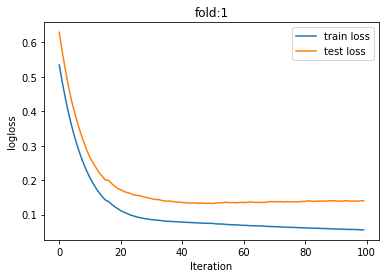

[I 2021-12-27 16:40:20,082] A new study created in memory with name: no-name-90df5e84-d709-43af-8e06-b02362e2e263
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.045936:  14%|######4                                      | 1/7 [00:00<00:03,  1.70it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0878328	Test's rmse: 0.0459358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.045936:  29%|############8                                | 2/7 [00:01<00:02,  1.71it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0848693	Test's rmse: 0.0667976
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.041491:  43%|###################2                         | 3/7 [00:01<00:02,  1.83it/s]

Early stopping, best iteration is:
[40]	Train's rmse: 0.102797	Test's rmse: 0.0414906
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.041491:  57%|#########################7                   | 4/7 [00:02<00:01,  1.79it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0873489	Test's rmse: 0.0817985
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.041491:  71%|################################1            | 5/7 [00:02<00:01,  1.69it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0913773	Test's rmse: 0.0431871
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.041491:  86%|######################################5      | 6/7 [00:03<00:00,  1.71it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0871374	Test's rmse: 0.08042
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.041491: 100%|#############################################| 7/7 [00:03<00:00,  1.76it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0838234	Test's rmse: 0.0548332


num_leaves, val_score: 0.041491:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

num_leaves, val_score: 0.041491:   5%|##5                                               | 1/20 [00:05<01:46,  5.61s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0928622	Test's rmse: 0.0419971
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.041376:  10%|#####                                             | 2/20 [00:08<01:07,  3.74s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.101227	Test's rmse: 0.0413757
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.041348:  15%|#######5                                          | 3/20 [00:09<00:42,  2.52s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.102972	Test's rmse: 0.0413485
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.041348:  20%|##########                                        | 4/20 [00:10<00:31,  1.98s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.102974	Test's rmse: 0.0413502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.041336:  25%|############5                                     | 5/20 [00:12<00:30,  2.06s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.101183	Test's rmse: 0.0413362
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.041293:  30%|###############                                   | 6/20 [00:14<00:27,  1.98s/it]

Early stopping, best iteration is:
[45]	Train's rmse: 0.101849	Test's rmse: 0.0412927
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.041293:  35%|#################5                                | 7/20 [00:15<00:23,  1.83s/it]

Early stopping, best iteration is:
[40]	Train's rmse: 0.102758	Test's rmse: 0.0414566
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.041293:  40%|####################                              | 8/20 [00:18<00:25,  2.15s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0929437	Test's rmse: 0.0415373
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.041293:  45%|######################5                           | 9/20 [00:21<00:25,  2.36s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0929807	Test's rmse: 0.0415812
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

num_leaves, val_score: 0.041293:  50%|########################5                        | 10/20 [00:25<00:28,  2.87s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0931118	Test's rmse: 0.0416094
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

num_leaves, val_score: 0.041293:  55%|##########################9                      | 11/20 [00:30<00:30,  3.40s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0928409	Test's rmse: 0.0416086
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.041293:  60%|#############################4                   | 12/20 [00:30<00:19,  2.45s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0931547	Test's rmse: 0.0422702
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.041175:  65%|###############################8                 | 13/20 [00:32<00:16,  2.33s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.101201	Test's rmse: 0.041175
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.041175:  70%|##################################3              | 14/20 [00:34<00:13,  2.26s/it]

Early stopping, best iteration is:
[49]	Train's rmse: 0.101118	Test's rmse: 0.0412913
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.041175:  75%|####################################7            | 15/20 [00:35<00:09,  1.82s/it]

Early stopping, best iteration is:
[40]	Train's rmse: 0.102797	Test's rmse: 0.0414906
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.041175:  80%|#######################################2         | 16/20 [00:37<00:08,  2.01s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.102928	Test's rmse: 0.041426
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

num_leaves, val_score: 0.041175:  85%|#########################################6       | 17/20 [00:41<00:07,  2.58s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.101191	Test's rmse: 0.0411751
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

num_leaves, val_score: 0.041175:  90%|############################################1    | 18/20 [00:47<00:06,  3.41s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.093146	Test's rmse: 0.0416889
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.041175:  95%|##############################################5  | 19/20 [00:51<00:03,  3.80s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0929437	Test's rmse: 0.0415373
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

num_leaves, val_score: 0.041175: 100%|#################################################| 20/20 [00:56<00:00,  2.83s/it]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0929758	Test's rmse: 0.0417288


bagging, val_score: 0.041175:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


bagging, val_score: 0.041175:  10%|#####3                                               | 1/10 [00:02<00:21,  2.34s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.101163	Test's rmse: 0.0564648
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


bagging, val_score: 0.041175:  20%|##########6                                          | 2/10 [00:04<00:18,  2.32s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.11847	Test's rmse: 0.0594615
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

bagging, val_score: 0.041175:  30%|###############9                                     | 3/10 [00:06<00:15,  2.19s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[96]	Train's rmse: 0.137485	Test's rmse: 0.0620857
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.041175:  40%|#####################2                               | 4/10 [00:08<00:12,  2.12s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.10377	Test's rmse: 0.0414219
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.041175:  50%|##########################5                          | 5/10 [00:10<00:09,  1.91s/it]

Early stopping, best iteration is:
[41]	Train's rmse: 0.0998688	Test's rmse: 0.0427828
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.041175:  60%|###############################8                     | 6/10 [00:12<00:07,  1.88s/it]

Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.0983978	Test's rmse: 0.0415892
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.041175:  70%|#####################################                | 7/10 [00:13<00:05,  1.86s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0906432	Test's rmse: 0.0426259
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

bagging, val_score: 0.041175:  80%|##########################################4          | 8/10 [00:15<00:03,  1.83s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133078	Test's rmse: 0.0715077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.041175:  90%|###############################################7     | 9/10 [00:18<00:02,  2.19s/it]

Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.101401	Test's rmse: 0.0414715
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

bagging, val_score: 0.041175: 100%|####################################################| 10/10 [00:21<00:00,  2.11s/it]


Early stopping, best iteration is:
[48]	Train's rmse: 0.139812	Test's rmse: 0.0629082


feature_fraction_stage2, val_score: 0.041175:   0%|                                              | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.041175:  33%|############6                         | 1/3 [00:02<00:05,  2.62s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.101201	Test's rmse: 0.041175
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.041175:  67%|#########################3            | 2/3 [00:05<00:02,  2.51s/it]

Early stopping, best iteration is:
[42]	Train's rmse: 0.101639	Test's rmse: 0.041892
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.041175: 100%|######################################| 3/3 [00:07<00:00,  2.57s/it]


Early stopping, best iteration is:
[42]	Train's rmse: 0.101885	Test's rmse: 0.0417375


regularization_factors, val_score: 0.041175:   0%|                                              | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

regularization_factors, val_score: 0.041175:   5%|#9                                    | 1/20 [00:01<00:24,  1.31s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0928895	Test's rmse: 0.0426568
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.041175:  10%|###8                                  | 2/20 [00:05<00:56,  3.16s/it]

Early stopping, best iteration is:
[42]	Train's rmse: 0.102559	Test's rmse: 0.0413406
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

regularization_factors, val_score: 0.041175:  15%|#####7                                | 3/20 [00:08<00:46,  2.75s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[48]	Train's rmse: 0.10056	Test's rmse: 0.0417264
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, b

regularization_factors, val_score: 0.041175:  20%|#######6                              | 4/20 [00:11<00:47,  2.98s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0932106	Test's rmse: 0.0411974
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

regularization_factors, val_score: 0.041175:  25%|#########5                            | 5/20 [00:12<00:35,  2.37s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0927405	Test's rmse: 0.0417329
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
[LightGBM] [Warning] No furthe

regularization_factors, val_score: 0.041175:  30%|###########4                          | 6/20 [00:15<00:36,  2.58s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.093577	Test's rmse: 0.0425806
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

regularization_factors, val_score: 0.041175:  35%|#############3                        | 7/20 [00:19<00:37,  2.86s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0922448	Test's rmse: 0.0418123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

regularization_factors, val_score: 0.041175:  40%|###############2                      | 8/20 [00:21<00:31,  2.63s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.103092	Test's rmse: 0.0415245
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

regularization_factors, val_score: 0.041175:  45%|#################1                    | 9/20 [00:22<00:24,  2.22s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[49]	Train's rmse: 0.10052	Test's rmse: 0.0419755
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve

regularization_factors, val_score: 0.041175:  50%|##################5                  | 10/20 [00:25<00:23,  2.37s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0929986	Test's rmse: 0.0416227
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

regularization_factors, val_score: 0.041175:  55%|####################3                | 11/20 [00:26<00:19,  2.17s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.104142	Test's rmse: 0.0415923
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.041175:  60%|######################2              | 12/20 [00:30<00:20,  2.59s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0929252	Test's rmse: 0.0415765
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.041175:  65%|########################             | 13/20 [00:33<00:19,  2.82s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.101198	Test's rmse: 0.0412183
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.041175:  70%|#########################9           | 14/20 [00:36<00:16,  2.71s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.101221	Test's rmse: 0.0412265
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

regularization_factors, val_score: 0.041175:  75%|###########################7         | 15/20 [00:38<00:12,  2.59s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.100866	Test's rmse: 0.0419374
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.041175:  80%|#############################6       | 16/20 [00:41<00:10,  2.66s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0929001	Test's rmse: 0.0413836
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.041175:  85%|###############################4     | 17/20 [00:44<00:08,  2.73s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0929999	Test's rmse: 0.0416707
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.041175:  90%|#################################3   | 18/20 [00:46<00:05,  2.65s/it]

Early stopping, best iteration is:
[37]	Train's rmse: 0.103321	Test's rmse: 0.0422961
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

regularization_factors, val_score: 0.041175:  95%|###################################1 | 19/20 [00:49<00:02,  2.76s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0929774	Test's rmse: 0.0416159
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

regularization_factors, val_score: 0.041175: 100%|#####################################| 20/20 [00:52<00:00,  2.61s/it]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0953438	Test's rmse: 0.0427194


min_data_in_leaf, val_score: 0.041175:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.041175:  20%|#########                                    | 1/5 [00:03<00:14,  3.55s/it]

Early stopping, best iteration is:
[47]	Train's rmse: 0.10289	Test's rmse: 0.042147
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

min_data_in_leaf, val_score: 0.041175:  40%|##################                           | 2/5 [00:04<00:06,  2.16s/it]

Early stopping, best iteration is:
[28]	Train's rmse: 0.205003	Test's rmse: 0.121205
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.041175:  60%|###########################                  | 3/5 [00:07<00:04,  2.45s/it]

Early stopping, best iteration is:
[32]	Train's rmse: 0.0620553	Test's rmse: 0.0499654
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

min_data_in_leaf, val_score: 0.041175:  80%|####################################         | 4/5 [00:10<00:02,  2.56s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 6535, number of used features: 20
[LightGBM] [Info] Start training from score 0.332607
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.041175: 100%|#############################################| 5/5 [00:12<00:00,  2.58s/it]

Early stopping, best iteration is:
[33]	Train's rmse: 0.0814987	Test's rmse: 0.0624576


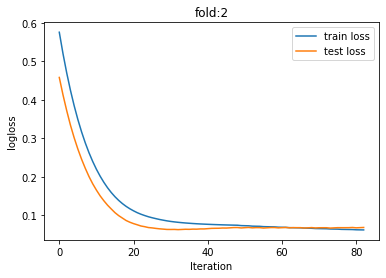

[I 2021-12-27 16:42:55,010] A new study created in memory with name: no-name-54be7285-51a0-4053-9e28-22f49dbef5e5
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.055589:  14%|######4                                      | 1/7 [00:00<00:05,  1.12it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0916747	Test's rmse: 0.0555885
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.054967:  29%|############8                                | 2/7 [00:01<00:03,  1.37it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.093305	Test's rmse: 0.0549673
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.054967:  43%|###################2                         | 3/7 [00:02<00:04,  1.03s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0850583	Test's rmse: 0.0847585
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.054967:  57%|#########################7                   | 4/7 [00:03<00:03,  1.03s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.086654	Test's rmse: 0.101458
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.054967:  71%|################################1            | 5/7 [00:04<00:01,  1.07it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0874709	Test's rmse: 0.0589373
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.054967:  86%|######################################5      | 6/7 [00:05<00:00,  1.01it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0880923	Test's rmse: 0.103241
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.054967: 100%|#############################################| 7/7 [00:06<00:00,  1.04it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0857454	Test's rmse: 0.070889


num_leaves, val_score: 0.054967:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

num_leaves, val_score: 0.054967:   5%|##5                                               | 1/20 [00:02<00:45,  2.42s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.093537	Test's rmse: 0.0551969
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

num_leaves, val_score: 0.054967:  10%|#####                                             | 2/20 [00:06<01:02,  3.47s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0935819	Test's rmse: 0.0551724
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

num_leaves, val_score: 0.054967:  15%|#######5                                          | 3/20 [00:08<00:49,  2.92s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0935002	Test's rmse: 0.0553353
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

num_leaves, val_score: 0.054967:  20%|##########                                        | 4/20 [00:11<00:45,  2.82s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0935187	Test's rmse: 0.0553061
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.054967:  25%|############5                                     | 5/20 [00:12<00:29,  2.00s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0936424	Test's rmse: 0.0551369
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.054962:  30%|###############                                   | 6/20 [00:13<00:24,  1.76s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0935175	Test's rmse: 0.0549619
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.054962:  35%|#################5                                | 7/20 [00:14<00:18,  1.43s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0938181	Test's rmse: 0.055375
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

num_leaves, val_score: 0.054962:  40%|####################                              | 8/20 [00:16<00:20,  1.72s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0935259	Test's rmse: 0.0553402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.054962:  45%|######################5                           | 9/20 [00:17<00:14,  1.35s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0935645	Test's rmse: 0.0551568
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.054962:  50%|########################5                        | 10/20 [00:18<00:12,  1.29s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0934892	Test's rmse: 0.0552794
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.054962:  55%|##########################9                      | 11/20 [00:19<00:12,  1.34s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0935319	Test's rmse: 0.0550569
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.054962:  60%|#############################4                   | 12/20 [00:21<00:10,  1.35s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0935319	Test's rmse: 0.0550569
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.054962:  65%|###############################8                 | 13/20 [00:22<00:09,  1.31s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.093478	Test's rmse: 0.0553746
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

num_leaves, val_score: 0.054962:  70%|##################################3              | 14/20 [00:24<00:08,  1.46s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0936057	Test's rmse: 0.0553049
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.054962:  75%|####################################7            | 15/20 [00:25<00:06,  1.35s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.093333	Test's rmse: 0.0549633
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	Train's rmse: 0.102789	Test's rmse: 0.0565286


num_leaves, val_score: 0.054962:  80%|#######################################2         | 16/20 [00:25<00:03,  1.01it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.054962:  85%|#########################################6       | 17/20 [00:26<00:03,  1.11s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0932469	Test's rmse: 0.0550462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

num_leaves, val_score: 0.054962:  90%|############################################1    | 18/20 [00:28<00:02,  1.46s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0935264	Test's rmse: 0.0553774
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.054962:  95%|##############################################5  | 19/20 [00:29<00:01,  1.33s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0935095	Test's rmse: 0.0554193
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.054962: 100%|#################################################| 20/20 [00:32<00:00,  1.63s/it]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0933361	Test's rmse: 0.0552474


bagging, val_score: 0.054962:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


bagging, val_score: 0.054962:  10%|#####3                                               | 1/10 [00:02<00:20,  2.28s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128392	Test's rmse: 0.0776213
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


bagging, val_score: 0.054962:  20%|##########6                                          | 2/10 [00:04<00:20,  2.51s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.100015	Test's rmse: 0.0568212
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


bagging, val_score: 0.054962:  30%|###############9                                     | 3/10 [00:06<00:15,  2.21s/it]

Early stopping, best iteration is:
[32]	Train's rmse: 0.130624	Test's rmse: 0.0743804
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


bagging, val_score: 0.054962:  40%|#####################2                               | 4/10 [00:08<00:12,  2.04s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.107306	Test's rmse: 0.0694788
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


bagging, val_score: 0.054962:  50%|##########################5                          | 5/10 [00:10<00:09,  1.92s/it]

Did not meet early stopping. Best iteration is:
[90]	Train's rmse: 0.138754	Test's rmse: 0.0821367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


bagging, val_score: 0.054962:  60%|###############################8                     | 6/10 [00:12<00:07,  1.86s/it]

Did not meet early stopping. Best iteration is:
[90]	Train's rmse: 0.104035	Test's rmse: 0.0627578
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.050887:  70%|#####################################                | 7/10 [00:14<00:05,  1.96s/it]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0935237	Test's rmse: 0.0508865
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.050887:  80%|##########################################4          | 8/10 [00:16<00:04,  2.05s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0921831	Test's rmse: 0.0565407
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


bagging, val_score: 0.050887:  90%|###############################################7     | 9/10 [00:17<00:01,  1.84s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.103773	Test's rmse: 0.0533467
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


bagging, val_score: 0.050887: 100%|####################################################| 10/10 [00:19<00:00,  1.93s/it]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.107392	Test's rmse: 0.0661097


feature_fraction_stage2, val_score: 0.050887:   0%|                                              | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.050887:  33%|############6                         | 1/3 [00:01<00:03,  1.70s/it]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0935237	Test's rmse: 0.0508865
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.050887:  67%|#########################3            | 2/3 [00:03<00:01,  1.60s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0931079	Test's rmse: 0.0542691
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.050887: 100%|######################################| 3/3 [00:05<00:00,  1.70s/it]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.093616	Test's rmse: 0.0519715


regularization_factors, val_score: 0.050887:   0%|                                              | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

regularization_factors, val_score: 0.050771:   5%|#9                                    | 1/20 [00:01<00:32,  1.69s/it]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0933947	Test's rmse: 0.0507706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

regularization_factors, val_score: 0.050771:  10%|###8                                  | 2/20 [00:02<00:25,  1.43s/it]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0943301	Test's rmse: 0.0531384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

regularization_factors, val_score: 0.050771:  15%|#####7                                | 3/20 [00:03<00:18,  1.10s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

regularization_factors, val_score: 0.050771:  20%|#######6                              | 4/20 [00:05<00:24,  1.53s/it]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.093438	Test's rmse: 0.0521168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

regularization_factors, val_score: 0.050097:  25%|#########5                            | 5/20 [00:06<00:20,  1.38s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0941398	Test's rmse: 0.0500974
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data poin

regularization_factors, val_score: 0.050097:  30%|###########4                          | 6/20 [00:07<00:16,  1.15s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0950988	Test's rmse: 0.053205
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

regularization_factors, val_score: 0.050097:  35%|#############3                        | 7/20 [00:07<00:11,  1.14it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

regularization_factors, val_score: 0.050097:  40%|###############2                      | 8/20 [00:08<00:10,  1.11it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.0936593	Test's rmse: 0.053827
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't impr

regularization_factors, val_score: 0.050097:  45%|#################1                    | 9/20 [00:10<00:13,  1.24s/it]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0934276	Test's rmse: 0.0509507
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

regularization_factors, val_score: 0.050097:  50%|##################5                  | 10/20 [00:11<00:09,  1.02it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[44]	Train's rmse: 0.107076	Test's rmse: 0.0514399
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points 

regularization_factors, val_score: 0.050097:  55%|####################3                | 11/20 [00:12<00:10,  1.20s/it]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0933697	Test's rmse: 0.0503567
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

regularization_factors, val_score: 0.050097:  60%|######################2              | 12/20 [00:14<00:10,  1.29s/it]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0939182	Test's rmse: 0.0519608
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

regularization_factors, val_score: 0.050097:  65%|########################             | 13/20 [00:15<00:09,  1.32s/it]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0940815	Test's rmse: 0.0510116
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


regularization_factors, val_score: 0.050097:  70%|#########################9           | 14/20 [00:17<00:07,  1.30s/it]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.09349	Test's rmse: 0.0510019
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

regularization_factors, val_score: 0.050097:  75%|###########################7         | 15/20 [00:18<00:06,  1.28s/it]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0939187	Test's rmse: 0.052055
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

regularization_factors, val_score: 0.050097:  80%|#############################6       | 16/20 [00:19<00:05,  1.28s/it]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0937028	Test's rmse: 0.0512353
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


regularization_factors, val_score: 0.050097:  85%|###############################4     | 17/20 [00:22<00:04,  1.65s/it]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0934463	Test's rmse: 0.0509602
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

regularization_factors, val_score: 0.050097:  90%|#################################3   | 18/20 [00:24<00:03,  1.88s/it]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0938542	Test's rmse: 0.0519911
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


regularization_factors, val_score: 0.050097:  95%|###################################1 | 19/20 [00:28<00:02,  2.42s/it]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0934922	Test's rmse: 0.0508527
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

regularization_factors, val_score: 0.050097: 100%|#####################################| 20/20 [00:30<00:00,  1.55s/it]


Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0937149	Test's rmse: 0.0532462


min_data_in_leaf, val_score: 0.050097:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

min_data_in_leaf, val_score: 0.050097:  20%|#########                                    | 1/5 [00:01<00:05,  1.41s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13013	Test's rmse: 0.0860762
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

min_data_in_leaf, val_score: 0.050097:  40%|##################                           | 2/5 [00:03<00:05,  1.86s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.0712136	Test's rmse: 0.0612572
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

min_data_in_leaf, val_score: 0.050097:  60%|###########################                  | 3/5 [00:04<00:02,  1.30s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

min_data_in_leaf, val_score: 0.050097:  80%|####################################         | 4/5 [00:06<00:01,  1.75s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0321839	Test's rmse: 0.0741175
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6505, number of used features: 20
[LightGBM] [Info] Start training from score 0.308812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

min_data_in_leaf, val_score: 0.050097: 100%|#############################################| 5/5 [00:08<00:00,  1.65s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.167811	Test's rmse: 0.107497


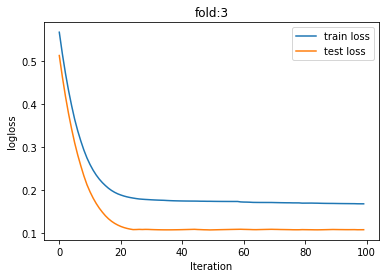

[I 2021-12-27 16:44:38,459] A new study created in memory with name: no-name-5b5700db-9690-406e-a036-24f0d1e43506
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.069493:  14%|######4                                      | 1/7 [00:01<00:06,  1.06s/it]

Early stopping, best iteration is:
[41]	Train's rmse: 0.107971	Test's rmse: 0.069493
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.069493:  29%|############8                                | 2/7 [00:02<00:05,  1.14s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.09078	Test's rmse: 0.0866318
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.069493:  43%|###################2                         | 3/7 [00:03<00:04,  1.24s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0879685	Test's rmse: 0.0858773
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.058714:  57%|#########################7                   | 4/7 [00:04<00:03,  1.14s/it]

Early stopping, best iteration is:
[27]	Train's rmse: 0.113578	Test's rmse: 0.0587139
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.058714:  71%|################################1            | 5/7 [00:05<00:02,  1.12s/it]

Early stopping, best iteration is:
[35]	Train's rmse: 0.109807	Test's rmse: 0.0630412
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.058714:  86%|######################################5      | 6/7 [00:06<00:01,  1.17s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0867503	Test's rmse: 0.0757051
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.058714: 100%|#############################################| 7/7 [00:08<00:00,  1.15s/it]


Early stopping, best iteration is:
[27]	Train's rmse: 0.112621	Test's rmse: 0.0588968


num_leaves, val_score: 0.058714:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.058714:   5%|##5                                               | 1/20 [00:01<00:29,  1.58s/it]

Early stopping, best iteration is:
[28]	Train's rmse: 0.111247	Test's rmse: 0.0594104
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.058714:  10%|#####                                             | 2/20 [00:04<00:42,  2.34s/it]

Early stopping, best iteration is:
[27]	Train's rmse: 0.113427	Test's rmse: 0.0590518
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.058702:  15%|#######5                                          | 3/20 [00:05<00:26,  1.58s/it]

Early stopping, best iteration is:
[28]	Train's rmse: 0.111941	Test's rmse: 0.0587017
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

num_leaves, val_score: 0.058702:  20%|##########                                        | 4/20 [00:08<00:36,  2.26s/it]

Early stopping, best iteration is:
[27]	Train's rmse: 0.113421	Test's rmse: 0.0590419
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.058702:  25%|############5                                     | 5/20 [00:10<00:34,  2.27s/it]

Early stopping, best iteration is:
[27]	Train's rmse: 0.113435	Test's rmse: 0.0589977
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

num_leaves, val_score: 0.058702:  30%|###############                                   | 6/20 [00:14<00:38,  2.75s/it]

Early stopping, best iteration is:
[28]	Train's rmse: 0.111169	Test's rmse: 0.0595541
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

num_leaves, val_score: 0.058702:  35%|#################5                                | 7/20 [00:17<00:39,  3.01s/it]

Early stopping, best iteration is:
[28]	Train's rmse: 0.11117	Test's rmse: 0.0595436
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

num_leaves, val_score: 0.058702:  40%|####################                              | 8/20 [00:21<00:39,  3.28s/it]

Early stopping, best iteration is:
[28]	Train's rmse: 0.111171	Test's rmse: 0.059543
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.058702:  45%|######################5                           | 9/20 [00:24<00:35,  3.23s/it]

Early stopping, best iteration is:
[27]	Train's rmse: 0.113437	Test's rmse: 0.0590027
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

num_leaves, val_score: 0.058702:  50%|########################5                        | 10/20 [00:28<00:31,  3.20s/it]

Early stopping, best iteration is:
[28]	Train's rmse: 0.111808	Test's rmse: 0.059023
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.058702:  55%|##########################9                      | 11/20 [00:28<00:20,  2.31s/it]

Early stopping, best iteration is:
[28]	Train's rmse: 0.112108	Test's rmse: 0.0602312
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.058702:  60%|#############################4                   | 12/20 [00:28<00:13,  1.73s/it]

Early stopping, best iteration is:
[28]	Train's rmse: 0.112108	Test's rmse: 0.0602312
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.058702:  65%|###############################8                 | 13/20 [00:30<00:11,  1.62s/it]

Early stopping, best iteration is:
[28]	Train's rmse: 0.11166	Test's rmse: 0.0599848
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.058702:  70%|##################################3              | 14/20 [00:31<00:09,  1.58s/it]

Early stopping, best iteration is:
[28]	Train's rmse: 0.111678	Test's rmse: 0.0599558
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.058702:  75%|####################################7            | 15/20 [00:33<00:09,  1.81s/it]

Early stopping, best iteration is:
[27]	Train's rmse: 0.113444	Test's rmse: 0.0589997
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

num_leaves, val_score: 0.058702:  80%|#######################################2         | 16/20 [00:38<00:10,  2.73s/it]

Early stopping, best iteration is:
[28]	Train's rmse: 0.111169	Test's rmse: 0.0595523
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.058633:  85%|#########################################6       | 17/20 [00:39<00:06,  2.25s/it]

Early stopping, best iteration is:
[27]	Train's rmse: 0.113523	Test's rmse: 0.0586334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.058579:  90%|############################################1    | 18/20 [00:41<00:03,  1.92s/it]

Early stopping, best iteration is:
[28]	Train's rmse: 0.111914	Test's rmse: 0.0585794
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.058579:  95%|##############################################5  | 19/20 [00:42<00:01,  1.64s/it]

Early stopping, best iteration is:
[27]	Train's rmse: 0.113582	Test's rmse: 0.0586943
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.058579: 100%|#################################################| 20/20 [00:43<00:00,  2.17s/it]


Early stopping, best iteration is:
[28]	Train's rmse: 0.111898	Test's rmse: 0.0587519


bagging, val_score: 0.058579:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.058579:  10%|#####3                                               | 1/10 [00:01<00:11,  1.25s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.140364	Test's rmse: 0.0618946
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.058579:  20%|##########6                                          | 2/10 [00:01<00:07,  1.08it/s]

Early stopping, best iteration is:
[37]	Train's rmse: 0.141458	Test's rmse: 0.062274
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.058527:  30%|###############9                                     | 3/10 [00:02<00:05,  1.26it/s]

Early stopping, best iteration is:
[28]	Train's rmse: 0.111524	Test's rmse: 0.0585275
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.058527:  40%|#####################2                               | 4/10 [00:03<00:04,  1.37it/s]

Early stopping, best iteration is:
[30]	Train's rmse: 0.114359	Test's rmse: 0.0634599
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.058527:  50%|##########################5                          | 5/10 [00:03<00:03,  1.46it/s]

Early stopping, best iteration is:
[29]	Train's rmse: 0.117103	Test's rmse: 0.06026
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.058527:  60%|###############################8                     | 6/10 [00:04<00:02,  1.49it/s]

Early stopping, best iteration is:
[30]	Train's rmse: 0.112614	Test's rmse: 0.0600253
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.058527:  70%|#####################################                | 7/10 [00:05<00:02,  1.49it/s]

Early stopping, best iteration is:
[37]	Train's rmse: 0.141672	Test's rmse: 0.0621485
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.055145:  80%|##########################################4          | 8/10 [00:05<00:01,  1.43it/s]

Early stopping, best iteration is:
[42]	Train's rmse: 0.14489	Test's rmse: 0.0551454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.055145:  90%|###############################################7     | 9/10 [00:06<00:00,  1.46it/s]

Early stopping, best iteration is:
[26]	Train's rmse: 0.115713	Test's rmse: 0.05979
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.055145: 100%|####################################################| 10/10 [00:07<00:00,  1.38it/s]


Early stopping, best iteration is:
[27]	Train's rmse: 0.114793	Test's rmse: 0.0588069


feature_fraction_stage2, val_score: 0.055145:   0%|                                              | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.055145:  17%|######3                               | 1/6 [00:00<00:03,  1.31it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138547	Test's rmse: 0.0594714
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.055145:  33%|############6                         | 2/6 [00:01<00:03,  1.08it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141388	Test's rmse: 0.0551901
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.055145:  50%|###################                   | 3/6 [00:02<00:02,  1.04it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136617	Test's rmse: 0.0612882
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.055145:  67%|#########################3            | 4/6 [00:03<00:01,  1.11it/s]

Early stopping, best iteration is:
[42]	Train's rmse: 0.14489	Test's rmse: 0.0551454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.055145:  83%|###############################6      | 5/6 [00:04<00:00,  1.20it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139769	Test's rmse: 0.0574874
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.055145: 100%|######################################| 6/6 [00:04<00:00,  1.21it/s]


Early stopping, best iteration is:
[42]	Train's rmse: 0.14489	Test's rmse: 0.0551454


regularization_factors, val_score: 0.055145:   0%|                                              | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.055145:   5%|#9                                    | 1/20 [00:00<00:16,  1.18it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139699	Test's rmse: 0.0560685
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.055145:  10%|###8                                  | 2/20 [00:02<00:20,  1.13s/it]

Early stopping, best iteration is:
[42]	Train's rmse: 0.14489	Test's rmse: 0.0551454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

regularization_factors, val_score: 0.055096:  15%|#####7                                | 3/20 [00:03<00:17,  1.00s/it]

Early stopping, best iteration is:
[42]	Train's rmse: 0.144962	Test's rmse: 0.0550964
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.054946:  20%|#######6                              | 4/20 [00:03<00:14,  1.13it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.144993	Test's rmse: 0.0549457
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.054770:  25%|#########5                            | 5/20 [00:04<00:13,  1.12it/s]

Early stopping, best iteration is:
[42]	Train's rmse: 0.145042	Test's rmse: 0.0547696
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

regularization_factors, val_score: 0.054770:  30%|###########4                          | 6/20 [00:05<00:13,  1.06it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140567	Test's rmse: 0.0555905
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.054656:  35%|#############3                        | 7/20 [00:07<00:13,  1.07s/it]

Early stopping, best iteration is:
[42]	Train's rmse: 0.145074	Test's rmse: 0.0546556
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

regularization_factors, val_score: 0.053507:  40%|###############2                      | 8/20 [00:07<00:10,  1.10it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

regularization_factors, val_score: 0.053507:  45%|#################1                    | 9/20 [00:08<00:10,  1.03it/s]

Early stopping, best iteration is:
[42]	Train's rmse: 0.145489	Test's rmse: 0.0543943
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

regularization_factors, val_score: 0.053507:  50%|##################5                  | 10/20 [00:09<00:09,  1.02it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.145466	Test's rmse: 0.05531
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

regularization_factors, val_score: 0.053507:  55%|####################3                | 11/20 [00:10<00:07,  1.21it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

regularization_factors, val_score: 0.053507:  60%|######################2              | 12/20 [00:10<00:05,  1.37it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141915	Test's rmse: 0.0594178
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

regularization_factors, val_score: 0.053507:  65%|########################             | 13/20 [00:12<00:07,  1.13s/it]

Early stopping, best iteration is:
[42]	Train's rmse: 0.145468	Test's rmse: 0.0544879
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.053507:  70%|#########################9           | 14/20 [00:13<00:06,  1.12s/it]

Early stopping, best iteration is:
[43]	Train's rmse: 0.145043	Test's rmse: 0.0543737
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.053507:  75%|###########################7         | 15/20 [00:14<00:05,  1.13s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140048	Test's rmse: 0.0547469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


regularization_factors, val_score: 0.053507:  80%|#############################6       | 16/20 [00:15<00:04,  1.08s/it]

Early stopping, best iteration is:
[42]	Train's rmse: 0.144927	Test's rmse: 0.0544085
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.053507:  85%|###############################4     | 17/20 [00:17<00:03,  1.14s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139693	Test's rmse: 0.0560051
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

regularization_factors, val_score: 0.053507:  90%|#################################3   | 18/20 [00:17<00:01,  1.06it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

regularization_factors, val_score: 0.053507:  95%|###################################1 | 19/20 [00:18<00:00,  1.20it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

regularization_factors, val_score: 0.053507: 100%|#####################################| 20/20 [00:19<00:00,  1.04it/s]


Early stopping, best iteration is:
[42]	Train's rmse: 0.144948	Test's rmse: 0.0544026


min_data_in_leaf, val_score: 0.053507:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

min_data_in_leaf, val_score: 0.053507:  20%|#########                                    | 1/5 [00:00<00:02,  1.91it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

min_data_in_leaf, val_score: 0.053507:  40%|##################                           | 2/5 [00:00<00:01,  2.11it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[34]	Train's rmse: 0.111481	Test's rmse: 0.0542065
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001470 seconds.
You can set `force_col_wise=true` to remove the overhead.

min_data_in_leaf, val_score: 0.053507:  60%|###########################                  | 3/5 [00:01<00:00,  2.17it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[31]	Train's rmse: 0.0996412	Test's rmse: 0.0658731
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain,

min_data_in_leaf, val_score: 0.053507:  60%|###########################                  | 3/5 [00:01<00:00,  2.17it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

min_data_in_leaf, val_score: 0.053507:  80%|####################################         | 4/5 [00:01<00:00,  2.11it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 6608, number of used features: 20
[LightGBM] [Info] Start training from score 0.325676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

min_data_in_leaf, val_score: 0.053507: 100%|#############################################| 5/5 [00:02<00:00,  2.12it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141894	Test's rmse: 0.0592928


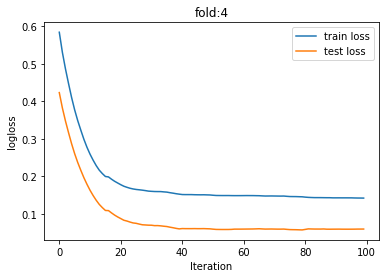

RMSE: [0.19903303283501944, 0.14004996831640767, 0.041174994093648026, 0.05009737563480206, 0.053507036236451325]
RMSE: 0.0967724814232657


In [17]:
gkf = GroupKFold(n_splits=5)

groups = X_train_normal["Genre"]

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 多クラス分類を指定
          'metric': 'rmse',  # 多クラス分類の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'seed': SEED                   # シード値
          }

best_params, history = {}, []

cv_result_rm_out = []

for fold, (train_index, test_index) in enumerate(gkf.split(X_train_normal, y_train_normal, groups)):
    X_train_gkf, X_test_gkf = X_train_normal.iloc[train_index], X_train_normal.iloc[test_index]
    y_train_gkf, y_test_gkf =  y_train_normal.iloc[train_index],  y_train_normal.iloc[test_index]

    # 学習、推論
    lgb_train = lgb.Dataset(X_train_gkf, y_train_gkf)
    lgb_test = lgb.Dataset(X_test_gkf, y_test_gkf, reference=lgb_train)

    lgb_results = {}                                    # 学習の履歴を入れる入物

    model = lgb.train(
                    params,                    # ハイパーパラメータをセット
                    lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    verbose_eval=-1,                  # ログを最後の1つだけ表示
                    )  
    
    best_params = model.params

   # 損失推移を表示
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')

    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    y_pred = model.predict(X_test_gkf, num_iteration=model.best_iteration)

    # 評価
    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result_rm_out.append(rmse)

print("RMSE:", cv_result_rm_out)
print("RMSE:", np.mean(cv_result_rm_out))

In [18]:
print("RMSE:", round(np.mean(cv_result_dropna), 3))
print("外れ値除去 RMSE:", round(np.mean(cv_result_rm_out), 3))

RMSE: 0.176
外れ値除去 RMSE: 0.097
